# Imports

In [3]:
import pandas as pd
import seaborn as sns
import sklearn as sk
import datetime as dt
import numpy as np

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data Processing

## Selection of features

In [4]:
#Selection of existing relevant features per game : events that happened during each game
relevant_features = ['Date','HomeTeam','AwayTeam','IWH','IWD','IWA','FTR','FTHG','FTAG','HTHG','HTAG','HS','AS',
                     'HST','AST','HF','AF','HY','AY','HR','AR','HC','AC']

## Function for data processing of each season : creation of relevant features

In [5]:
def create_stat_dico(season: str, league: str) -> pd.DataFrame:
    
    """Compute statistics for a given season all the relevant statistics by going through each game
    
    Output a Dataframe of each game and each team statistics before the game
    
    Arguments : name of the season as a string, name of the league as a string
    """
    
    #stat_seasons is a 3-layer nested dico :
    # stats_season ---> dico of all clubs
    # club ---> dico of all week results
    # week ---> all stats for that week
    # stat ---> value for that specific game
     
    stats_season = {}
    file_name = '/Users/theophanegregoir/Desktop/BettingAI/Football_Data/European_Leagues/Entire_Data_' + league + '.xlsx'
    xls_file = pd.ExcelFile(file_name)
    table = xls_file.parse(season)[relevant_features].dropna(axis=0)
    
    ###Features that describe team before the game
    table['week'] = 0
    
    ###For Home Team (HT)
    table['HT_league_points'] = 0.0
    table['HT_average_goal_scored'] = 0.0
    table['HT_average_goal_conceeded'] = 0.0
    table['HT_average_goal_scored_half'] = 0.0
    table['HT_average_goal_conceeded_half'] = 0.0
    table['HT_average_yellow'] = 0.0
    table['HT_average_red'] = 0.0
    table['HT_average_shots'] = 0.0
    table['HT_average_shots_on_target'] = 0.0
    table['HT_average_shots_conceeded'] = 0.0
    table['HT_average_fouls_committed'] = 0.0
    table['HT_average_fouls_conceeded'] = 0.0
    
    ###For Away Team (AT)
    table['AT_league_points'] = 0.0
    table['AT_average_goal_scored'] = 0.0
    table['AT_average_goal_conceeded'] = 0.0
    table['AT_average_goal_scored_half'] = 0.0
    table['AT_average_goal_conceeded_half'] = 0.0
    table['AT_average_yellow'] = 0.0
    table['AT_average_red'] = 0.0
    table['AT_average_shots'] = 0.0
    table['AT_average_shots_on_target'] = 0.0
    table['AT_average_shots_conceeded'] = 0.0
    table['AT_average_fouls_committed'] = 0.0
    table['AT_average_fouls_conceeded'] = 0.0
    
    #Number of weeks available
    nb_weeks = int(len(table)/10)
    
    if season == '2019-2020':
        nb_weeks = int(len(table)/10) - 1
    
    #Getting unique list of club names for this season
    clubs = list(set(list(table['HomeTeam'])))

    #Creation of the dictionary of stats for each club       
    for c in clubs:
        
        #First layer of dict
        stats_season[c] = {}
        
        #Selection of the games where the club is involved
        isHome = table['HomeTeam'] == c
        isAway = table['AwayTeam'] == c
        selected = table.loc[isHome | isAway]
        stats_season[c]['games_index'] = list(selected.index)
        
        
        #Initialisation of week 0 for additive params
        stats_season[c][0] = {}
        stats_season[c][0]['league_points'] = 0.0
        stats_season[c][0]['goals_scored'] = 0.0
        stats_season[c][0]['goals_scored_half'] = 0.0
        stats_season[c][0]['goals_conceeded'] = 0.0
        stats_season[c][0]['goals_conceeded_half'] = 0.0
        stats_season[c][0]['yellow'] = 0.0
        stats_season[c][0]['red'] = 0.0
        stats_season[c][0]['fouls_conceeded'] = 0.0
        stats_season[c][0]['fouls_committed'] = 0.0
        stats_season[c][0]['shots'] = 0.0
        stats_season[c][0]['shots_on_target'] = 0.0
        stats_season[c][0]['shots_conceeded'] = 0.0
        
        #Going through all the weeks of the season
        for k in range(1,len(selected)):
            
            #Second layer of dict
            stats_season[c][k] = {}
            
            #Third layer of dict
            if selected['AwayTeam'][selected.index[k-1]] == c :
                stats_season[c][k]['is_Home'] = False
            else :
                stats_season[c][k]['is_Home'] = True
            
            #Modifying the dataframe to add the statistics before game (based on previous weeks) use as features for ML
            if stats_season[c][k]['is_Home']:
                table.at[selected.index[k-1],'week'] = k
                table.at[selected.index[k-1],'HT_league_points'] = stats_season[c][k-1]['league_points'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_scored'] = stats_season[c][k-1]['goals_scored'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_conceeded'] = stats_season[c][k-1]['goals_conceeded'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_scored_half'] = stats_season[c][k-1]['goals_scored_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_conceeded_half'] =  stats_season[c][k-1]['goals_conceeded_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_shots'] = stats_season[c][k-1]['shots'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_shots_on_target'] = stats_season[c][k-1]['shots_on_target'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_shots_conceeded']= stats_season[c][k-1]['shots_conceeded'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_yellow'] = stats_season[c][k-1]['yellow'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_red'] = stats_season[c][k-1]['red'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_fouls_committed'] = stats_season[c][k-1]['fouls_committed'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] / max(k-1.0,1.0)
            else :
                table.at[selected.index[k-1],'AT_league_points'] = stats_season[c][k-1]['league_points'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_scored'] = stats_season[c][k-1]['goals_scored'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_conceeded'] = stats_season[c][k-1]['goals_conceeded'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_scored_half'] = stats_season[c][k-1]['goals_scored_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_conceeded_half'] =  stats_season[c][k-1]['goals_conceeded_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_shots'] = stats_season[c][k-1]['shots'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_shots_on_target'] = stats_season[c][k-1]['shots_on_target'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_shots_conceeded']= stats_season[c][k-1]['shots_conceeded'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_yellow'] = stats_season[c][k-1]['yellow'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_red'] = stats_season[c][k-1]['red'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_fouls_committed'] = stats_season[c][k-1]['fouls_committed'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] / max(k-1.0,1.0)
            
            #Gathering the statistics of the game for the club for next games
            #League points
            if selected['FTR'][selected.index[k-1]] == "D" :
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 1.0
            elif selected['FTR'][selected.index[k-1]] == "A" and selected['AwayTeam'][selected.index[k-1]] == c:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 3.0
            elif selected['FTR'][selected.index[k-1]] == "H" and selected['HomeTeam'][selected.index[k-1]] == c:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 3.0
            else:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points']
            
            #Goals and shots
            if stats_season[c][k]['is_Home']:
                stats_season[c][k]['goals_scored'] = stats_season[c][k-1]['goals_scored'] + selected['FTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_scored_half'] = stats_season[c][k-1]['goals_scored_half'] + selected['HTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded'] = stats_season[c][k-1]['goals_conceeded'] + selected['FTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded_half'] = stats_season[c][k-1]['goals_conceeded_half'] + selected['HTAG'][selected.index[k-1]]
                stats_season[c][k]['shots'] = stats_season[c][k-1]['shots'] + selected['HS'][selected.index[k-1]]
                stats_season[c][k]['shots_on_target'] = stats_season[c][k-1]['shots_on_target'] + selected['HST'][selected.index[k-1]]
                stats_season[c][k]['shots_conceeded'] = stats_season[c][k-1]['shots_conceeded'] + selected['AS'][selected.index[k-1]]
            else :
                stats_season[c][k]['goals_scored'] = stats_season[c][k-1]['goals_scored'] + selected['FTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_scored_half'] = stats_season[c][k-1]['goals_scored_half'] + selected['HTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded'] = stats_season[c][k-1]['goals_conceeded'] + selected['FTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded_half'] = stats_season[c][k-1]['goals_conceeded_half'] + selected['HTHG'][selected.index[k-1]]
                stats_season[c][k]['shots'] = stats_season[c][k-1]['shots'] + selected['AS'][selected.index[k-1]]
                stats_season[c][k]['shots_on_target'] = stats_season[c][k-1]['shots_on_target'] + selected['AST'][selected.index[k-1]]
                stats_season[c][k]['shots_conceeded'] = stats_season[c][k-1]['shots_conceeded'] + selected['HS'][selected.index[k-1]]
            
            #Fouls and cards
            if stats_season[c][k]['is_Home']:
                stats_season[c][k]['yellow'] = stats_season[c][k-1]['yellow'] + selected['HY'][selected.index[k-1]]
                stats_season[c][k]['red'] = stats_season[c][k-1]['red'] + selected['HR'][selected.index[k-1]]
                stats_season[c][k]['fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] + selected['AF'][selected.index[k-1]]
                stats_season[c][k]['fouls_committed'] = stats_season[c][k-1]['fouls_committed'] + selected['HF'][selected.index[k-1]]
            else:
                stats_season[c][k]['yellow'] = stats_season[c][k-1]['yellow'] + selected['AY'][selected.index[k-1]]
                stats_season[c][k]['red'] = stats_season[c][k-1]['red'] + selected['AR'][selected.index[k-1]]
                stats_season[c][k]['fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] + selected['HF'][selected.index[k-1]]
                stats_season[c][k]['fouls_committed'] = stats_season[c][k-1]['fouls_committed'] + selected['AF'][selected.index[k-1]]
    
    valid = table['week'] > 5
    
    return(table[valid])

## Processing selected data

In [6]:
#List of all features created after processing
processed_features = ['week', 'HT_league_points', 'HT_average_goal_scored',
           'HT_average_goal_conceeded', 'HT_average_goal_scored_half',
           'HT_average_goal_conceeded_half', 'HT_average_yellow', 'HT_average_red',
           'HT_average_shots', 'HT_average_shots_on_target',
           'HT_average_shots_conceeded', 'HT_average_fouls_committed',
           'HT_average_fouls_conceeded', 'AT_league_points',
           'AT_average_goal_scored', 'AT_average_goal_conceeded',
           'AT_average_goal_scored_half', 'AT_average_goal_conceeded_half',
           'AT_average_yellow', 'AT_average_red', 'AT_average_shots',
           'AT_average_shots_on_target', 'AT_average_shots_conceeded',
           'AT_average_fouls_committed', 'AT_average_fouls_conceeded','FTR','IWH','IWD','IWA']

#Leagues selected
chosen_leagues = ['PL', 'SerieA','Bundesliga']

#Seasons selected
start_year = 2010
end_year = 2020

data_seasons = {}

for i in range(start_year,end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    data_seasons[season] = {}
    
    for league in chosen_leagues:
        
        print("Processing " + league + ' ' + str(i) + '-' + str(i+1))

        table = create_stat_dico(season, league)

        full_table_add = table[processed_features]
        
        data_seasons[season][league] = full_table_add
 

Processing PL 2010-2011
Processing SerieA 2010-2011
Processing Bundesliga 2010-2011
Processing PL 2011-2012
Processing SerieA 2011-2012
Processing Bundesliga 2011-2012
Processing PL 2012-2013
Processing SerieA 2012-2013
Processing Bundesliga 2012-2013
Processing PL 2013-2014
Processing SerieA 2013-2014
Processing Bundesliga 2013-2014
Processing PL 2014-2015
Processing SerieA 2014-2015
Processing Bundesliga 2014-2015
Processing PL 2015-2016
Processing SerieA 2015-2016
Processing Bundesliga 2015-2016
Processing PL 2016-2017
Processing SerieA 2016-2017
Processing Bundesliga 2016-2017
Processing PL 2017-2018
Processing SerieA 2017-2018
Processing Bundesliga 2017-2018
Processing PL 2018-2019
Processing SerieA 2018-2019
Processing Bundesliga 2018-2019
Processing PL 2019-2020
Processing SerieA 2019-2020
Processing Bundesliga 2019-2020


## Visualize data final format

In [7]:
#Visualize the format of dataframe
full_table_add

,week,HT_league_points,HT_average_goal_scored,HT_average_goal_conceeded,HT_average_goal_scored_half,HT_average_goal_conceeded_half,HT_average_yellow,HT_average_red,HT_average_shots,HT_average_shots_on_target,...,AT_average_red,AT_average_shots,AT_average_shots_on_target,AT_average_shots_conceeded,AT_average_fouls_committed,AT_average_fouls_conceeded,FTR,IWH,IWD,IWA
45,6,0.800000,1.000000,2.000000,0.400000,1.400000,1.200000,0.600000,11.400000,3.000000,...,0.000000,16.600000,5.400000,12.200000,13.600000,10.400000,A,3.00,3.50,2.30
46,6,1.000000,1.400000,2.200000,1.000000,0.800000,2.000000,0.200000,10.000000,3.800000,...,0.000000,17.200000,6.400000,8.600000,9.200000,10.600000,A,4.55,4.50,1.63
47,6,1.000000,0.800000,1.400000,0.200000,1.000000,1.800000,0.000000,11.800000,3.000000,...,0.000000,16.000000,5.600000,15.000000,14.000000,14.800000,A,2.60,3.50,2.60
48,6,0.600000,1.000000,3.000000,0.600000,0.800000,2.200000,0.000000,15.000000,4.200000,...,0.000000,13.000000,4.800000,9.800000,11.600000,14.000000,A,2.90,3.55,2.35
49,6,0.200000,1.200000,2.800000,1.000000,1.200000,2.400000,0.000000,11.800000,4.000000,...,0.000000,16.800000,7.000000,10.000000,10.200000,14.200000,A,15.50,9.00,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,23,1.181818,1.227273,1.727273,0.454545,0.681818,2.181818,0.136364,10.136364,3.227273,...,0.142857,12.619048,4.476190,14.000000,13.952381,12.857143,A,2.40,3.40,2.90
200,22,2.000000,2.000000,1.142857,0.904762,0.428571,2.476190,0.095238,13.571429,5.666667,...,0.000000,13.136364,4.727273,14.409091,10.818182,12.500000,D,1.65,4.30,4.75
202,23,1.636364,1.454545,1.227273,0.454545,0.318182,1.727273,0.045455,12.000000,4.272727,...,0.045455,16.227273,6.681818,10.227273,10.409091,10.772727,A,4.15,3.95,1.80
203,23,1.818182,1.727273,1.318182,1.045455,0.636364,1.727273,0.272727,16.090909,6.636364,...,0.090909,11.454545,4.318182,14.636364,10.681818,11.318182,H,1.48,4.70,6.10


# Defining train and test datasets

## Training dataset

In [8]:
#Selection of seasons used to train
train_start_year = 2010
train_end_year = 2018

train_df = pd.DataFrame(columns = processed_features)

for i in range(train_start_year,train_end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    for league in chosen_leagues:
        
        table = data_seasons[season][league]
        
        two_concat = [train_df, table]
        
        train_df = pd.concat(two_concat)
        

print("The model will train on " + str(len(train_df)) + " matches !")

#Choice of the features
features = ['HT_league_points', 'HT_average_goal_scored',
       'HT_average_goal_conceeded', 'HT_average_goal_scored_half',
       'HT_average_goal_conceeded_half','HT_average_red',
       'HT_average_shots', 'HT_average_shots_on_target',
       'HT_average_shots_conceeded', 'AT_league_points',
       'AT_average_goal_scored', 'AT_average_goal_conceeded',
       'AT_average_goal_scored_half', 'AT_average_goal_conceeded_half',
       'AT_average_red', 'AT_average_shots',
       'AT_average_shots_on_target', 'AT_average_shots_conceeded']

n_features = len(features)

train_x = train_df[features]

train_y = train_df['FTR']


The model will train on 7112 matches !


## Testing dataset

In [9]:
#Selection of seasons used to test
test_start_year = 2017
test_end_year = 2020

test_df = pd.DataFrame(columns = processed_features)

for i in range(test_start_year,test_end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    for league in chosen_leagues:
        
        table = data_seasons[season][league]
        
        two_concat = [test_df, table]
        
        test_df = pd.concat(two_concat)

#Choice of the features (we first delete the odds)
test_x = test_df[features]

#Labels for training
test_y = test_df['FTR']

print("The model will test on " + str(len(test_df)) + " matches !")

The model will test on 2332 matches !


# Let's apply classical ML algorithms

## Importing models

In [10]:
#Dealing with format and metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

#Classical classifiers
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

#Ensemblist models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

#Neural Networks
from sklearn.neural_network import MLPClassifier

## Training and testing : getting probabilities for test data

In [11]:
# Dealing with parameters
C = 5.0

# Create different classifiers.
classifiers = {
    'L1 logistic': LogisticRegression(C=1.0, penalty='l1',
                                      solver='saga', tol=0.0001,
                                      multi_class='multinomial',
                                      max_iter=10000),
    'L2 logistic (Multinomial)': LogisticRegression(C=C, penalty='l2',
                                                    solver='saga',
                                                    multi_class='multinomial',
                                                    max_iter=10000),
    'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                            max_iter=10000),
    'Random Forest': RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=25, 
                                            min_samples_split=2, min_samples_leaf=1, 
                                            min_weight_fraction_leaf=0.0, max_features='auto', 
                                            max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                            min_impurity_split=None, bootstrap=True, oob_score=False, 
                                            n_jobs=None, random_state=None)
}

n_classifiers = len(classifiers)

results = {}

for index, (name, classifier) in enumerate(classifiers.items()):
    print("Training " + name + "...")
    classifier.fit(train_x, train_y)

    y_pred = classifier.predict(test_x)
    accuracy = accuracy_score(test_y, y_pred)
    print("Accuracy (test) for %s: %0.1f%% " % (name, accuracy * 100))
    
    #Calculate probabilities:
    probas = classifier.predict_proba(test_x)
    
    #store them in a dict
    results[name] = probas


Training L1 logistic...
Accuracy (test) for L1 logistic: 53.3% 
Training L2 logistic (Multinomial)...
Accuracy (test) for L2 logistic (Multinomial): 53.5% 
Training L2 logistic (OvR)...
Accuracy (test) for L2 logistic (OvR): 53.4% 
Training Random Forest...
Accuracy (test) for Random Forest: 70.9% 


# Let's try with Neural Networks

## Imports

In [16]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#Keras tuners
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

#Time
import time

## Parameters

In [13]:
n_classes = 3
n_features = train_x.shape[1]
n_epochs = 10

## Preprocessing

In [15]:
test_X = test_x.values
test_Y = test_y.values
train_X = train_x.values
train_Y = train_y.values

# integer encode
label_encoder = LabelEncoder()
train_Y_integer_encoded = label_encoder.fit_transform(train_Y)
test_Y_integer_encoded = label_encoder.transform(test_Y)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
train_Y_integer_encoded = train_Y_integer_encoded.reshape(len(train_Y_integer_encoded), 1)
train_Y_onehot_encoded = onehot_encoder.fit_transform(train_Y_integer_encoded)
test_Y_integer_encoded = test_Y_integer_encoded.reshape(len(test_Y_integer_encoded), 1)
test_Y_onehot_encoded = onehot_encoder.transform(test_Y_integer_encoded)


## Creation of the model

In [ ]:
log_dir = f"{int(time.time())}"

def build_model(hp):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(hp.Int("n_input_neurons",min_value = 10, max_value = 200, step = 20), input_dim=n_features, activation =tf.nn.relu))
    
    for i in range(hp.Int("n_layers", 1, 4)):
        model.add(tf.keras.layers.Dense(hp.Int(f"layer_{i}_neurons",min_value = 10, max_value = 200, step = 20), activation =tf.nn.relu))

    #Output layer
    model.add(tf.keras.layers.Dense(n_classes,activation =tf.nn.softmax))

    #Compile
    model.compile(optimizer = 'adam',
                  loss = 'categorical_crossentropy',
                  metrics = ["accuracy"])
    return model

tuner = RandomSearch(
        build_model,
        objective = "val_acc",
        max_trials = 100,
        executions_per_trial = 1,
        directory = log_dir
        )

tuner.search(x = train_X,
             y = train_Y_onehot_encoded,
             epochs = 10,
             batch_size = 10,
             validation_data = (test_X, test_Y_onehot_encoded))

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 5:17 - loss: 1.1910 - acc: 0.500 - ETA: 29s - loss: 1.3705 - acc: 0.291 - ETA: 32s - loss: 1.3456 - acc: 0.30 - ETA: 22s - loss: 1.2867 - acc: 0.30 - ETA: 13s - loss: 1.1998 - acc: 0.32 - ETA: 10s - loss: 1.1690 - acc: 0.37 - ETA: 8s - loss: 1.1444 - acc: 0.4133 - ETA: 8s - loss: 1.1322 - acc: 0.430 - ETA: 7s - loss: 1.1238 - acc: 0.432 - ETA: 7s - loss: 1.1244 - acc: 0.430 - ETA: 7s - loss: 1.1240 - acc: 0.427 - ETA: 7s - loss: 1.1187 - acc: 0.435 - ETA: 6s - loss: 1.1129 - acc: 0.441 - ETA: 6s - loss: 1.1091 - acc: 0.441 - ETA: 6s - loss: 1.1077 - acc: 0.442 - ETA: 5s - loss: 1.1037 - acc: 0.446 - ETA: 5s - loss: 1.1025 - acc: 0.446 - ETA: 5s - loss: 1.1011 - acc: 0.445 - ETA: 5s - loss: 1.0995 - acc: 0.445 - ETA: 5s - loss: 1.0988 - acc: 0.441 - ETA: 4s - loss: 1.0973 - acc: 0.444 - ETA: 4s - loss: 1.0963 - acc: 0.445 - ETA: 4s - loss: 1.0944 - acc: 0.447 - ETA: 4s - loss: 1.

7112/7112 [==============================] - ETA: 2s - loss: 0.8259 - acc: 0.700 - ETA: 10s - loss: 0.9501 - acc: 0.55 - ETA: 11s - loss: 0.9797 - acc: 0.51 - ETA: 17s - loss: 0.9627 - acc: 0.53 - ETA: 14s - loss: 1.0008 - acc: 0.50 - ETA: 9s - loss: 1.0345 - acc: 0.4810 - ETA: 7s - loss: 1.0319 - acc: 0.490 - ETA: 6s - loss: 1.0432 - acc: 0.485 - ETA: 5s - loss: 1.0286 - acc: 0.501 - ETA: 5s - loss: 1.0133 - acc: 0.517 - ETA: 5s - loss: 1.0169 - acc: 0.512 - ETA: 4s - loss: 1.0168 - acc: 0.515 - ETA: 4s - loss: 1.0087 - acc: 0.523 - ETA: 4s - loss: 1.0009 - acc: 0.530 - ETA: 4s - loss: 1.0016 - acc: 0.526 - ETA: 4s - loss: 1.0011 - acc: 0.528 - ETA: 4s - loss: 1.0083 - acc: 0.520 - ETA: 3s - loss: 1.0072 - acc: 0.524 - ETA: 3s - loss: 1.0064 - acc: 0.524 - ETA: 3s - loss: 1.0079 - acc: 0.522 - ETA: 3s - loss: 1.0068 - acc: 0.521 - ETA: 3s - loss: 1.0057 - acc: 0.524 - ETA: 3s - loss: 1.0069 - acc: 0.523 - ETA: 3s - loss: 1.0012 - acc: 0.530 - ETA: 3s - loss: 1.0003 - acc: 0.531 - ETA:

7112/7112 [==============================] - ETA: 3s - loss: 0.8568 - acc: 0.500 - ETA: 2s - loss: 0.9858 - acc: 0.540 - ETA: 2s - loss: 0.9689 - acc: 0.543 - ETA: 2s - loss: 0.9859 - acc: 0.527 - ETA: 2s - loss: 0.9822 - acc: 0.538 - ETA: 3s - loss: 0.9824 - acc: 0.539 - ETA: 2s - loss: 0.9947 - acc: 0.527 - ETA: 2s - loss: 0.9871 - acc: 0.535 - ETA: 2s - loss: 0.9894 - acc: 0.535 - ETA: 2s - loss: 0.9785 - acc: 0.543 - ETA: 2s - loss: 0.9811 - acc: 0.539 - ETA: 2s - loss: 0.9868 - acc: 0.535 - ETA: 3s - loss: 0.9867 - acc: 0.534 - ETA: 3s - loss: 0.9844 - acc: 0.537 - ETA: 3s - loss: 0.9843 - acc: 0.537 - ETA: 3s - loss: 0.9842 - acc: 0.532 - ETA: 3s - loss: 0.9819 - acc: 0.535 - ETA: 3s - loss: 0.9811 - acc: 0.536 - ETA: 3s - loss: 0.9820 - acc: 0.535 - ETA: 3s - loss: 0.9812 - acc: 0.532 - ETA: 3s - loss: 0.9807 - acc: 0.532 - ETA: 3s - loss: 0.9813 - acc: 0.533 - ETA: 3s - loss: 0.9796 - acc: 0.535 - ETA: 3s - loss: 0.9816 - acc: 0.534 - ETA: 3s - loss: 0.9820 - acc: 0.534 - ETA: 

7112/7112 [==============================] - ETA: 9s - loss: 0.8035 - acc: 0.600 - ETA: 9s - loss: 0.8755 - acc: 0.612 - ETA: 8s - loss: 0.9276 - acc: 0.576 - ETA: 6s - loss: 0.9660 - acc: 0.530 - ETA: 5s - loss: 0.9786 - acc: 0.520 - ETA: 4s - loss: 0.9713 - acc: 0.522 - ETA: 4s - loss: 0.9793 - acc: 0.507 - ETA: 4s - loss: 0.9753 - acc: 0.513 - ETA: 3s - loss: 0.9833 - acc: 0.509 - ETA: 3s - loss: 0.9822 - acc: 0.511 - ETA: 3s - loss: 0.9789 - acc: 0.513 - ETA: 3s - loss: 0.9807 - acc: 0.517 - ETA: 3s - loss: 0.9822 - acc: 0.519 - ETA: 3s - loss: 0.9805 - acc: 0.522 - ETA: 3s - loss: 0.9812 - acc: 0.521 - ETA: 3s - loss: 0.9827 - acc: 0.519 - ETA: 3s - loss: 0.9808 - acc: 0.521 - ETA: 3s - loss: 0.9833 - acc: 0.517 - ETA: 3s - loss: 0.9821 - acc: 0.518 - ETA: 3s - loss: 0.9815 - acc: 0.518 - ETA: 3s - loss: 0.9830 - acc: 0.517 - ETA: 3s - loss: 0.9815 - acc: 0.519 - ETA: 3s - loss: 0.9847 - acc: 0.516 - ETA: 3s - loss: 0.9844 - acc: 0.516 - ETA: 3s - loss: 0.9842 - acc: 0.518 - ETA: 

7112/7112 [==============================] - ETA: 7s - loss: 1.0768 - acc: 0.500 - ETA: 33s - loss: 0.9809 - acc: 0.60 - ETA: 9s - loss: 1.0394 - acc: 0.4727 - ETA: 6s - loss: 1.0082 - acc: 0.500 - ETA: 5s - loss: 0.9839 - acc: 0.535 - ETA: 4s - loss: 0.9918 - acc: 0.530 - ETA: 4s - loss: 0.9699 - acc: 0.543 - ETA: 4s - loss: 0.9683 - acc: 0.548 - ETA: 4s - loss: 0.9599 - acc: 0.561 - ETA: 4s - loss: 0.9571 - acc: 0.563 - ETA: 4s - loss: 0.9596 - acc: 0.561 - ETA: 3s - loss: 0.9570 - acc: 0.562 - ETA: 3s - loss: 0.9541 - acc: 0.566 - ETA: 3s - loss: 0.9492 - acc: 0.569 - ETA: 3s - loss: 0.9455 - acc: 0.574 - ETA: 3s - loss: 0.9463 - acc: 0.571 - ETA: 3s - loss: 0.9446 - acc: 0.572 - ETA: 3s - loss: 0.9493 - acc: 0.566 - ETA: 3s - loss: 0.9535 - acc: 0.564 - ETA: 3s - loss: 0.9549 - acc: 0.562 - ETA: 3s - loss: 0.9551 - acc: 0.561 - ETA: 3s - loss: 0.9563 - acc: 0.561 - ETA: 4s - loss: 0.9562 - acc: 0.562 - ETA: 4s - loss: 0.9587 - acc: 0.560 - ETA: 3s - loss: 0.9638 - acc: 0.554 - ETA:

7112/7112 [==============================] - ETA: 3s - loss: 1.1516 - acc: 0.400 - ETA: 3s - loss: 0.9714 - acc: 0.566 - ETA: 2s - loss: 0.9324 - acc: 0.576 - ETA: 3s - loss: 0.9539 - acc: 0.557 - ETA: 3s - loss: 0.9537 - acc: 0.560 - ETA: 4s - loss: 0.9496 - acc: 0.566 - ETA: 4s - loss: 0.9623 - acc: 0.557 - ETA: 3s - loss: 0.9521 - acc: 0.562 - ETA: 3s - loss: 0.9580 - acc: 0.558 - ETA: 4s - loss: 0.9667 - acc: 0.551 - ETA: 4s - loss: 0.9661 - acc: 0.550 - ETA: 4s - loss: 0.9665 - acc: 0.550 - ETA: 4s - loss: 0.9728 - acc: 0.546 - ETA: 5s - loss: 0.9743 - acc: 0.544 - ETA: 4s - loss: 0.9802 - acc: 0.542 - ETA: 4s - loss: 0.9789 - acc: 0.545 - ETA: 4s - loss: 0.9778 - acc: 0.543 - ETA: 4s - loss: 0.9730 - acc: 0.548 - ETA: 4s - loss: 0.9800 - acc: 0.543 - ETA: 4s - loss: 0.9838 - acc: 0.538 - ETA: 4s - loss: 0.9828 - acc: 0.538 - ETA: 3s - loss: 0.9813 - acc: 0.537 - ETA: 3s - loss: 0.9822 - acc: 0.536 - ETA: 3s - loss: 0.9808 - acc: 0.537 - ETA: 3s - loss: 0.9798 - acc: 0.539 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 11:25 - loss: 1.1040 - acc: 0.30 - ETA: 1:19 - loss: 1.3600 - acc: 0.3556 - ETA: 53s - loss: 1.2326 - acc: 0.392 - ETA: 38s - loss: 1.1768 - acc: 0.42 - ETA: 33s - loss: 1.1423 - acc: 0.43 - ETA: 30s - loss: 1.1077 - acc: 0.46 - ETA: 27s - loss: 1.1273 - acc: 0.45 - ETA: 24s - loss: 1.1044 - acc: 0.47 - ETA: 21s - loss: 1.0861 - acc: 0.49 - ETA: 20s - loss: 1.0697 - acc: 0.50 - ETA: 18s - loss: 1.0722 - acc: 0.50 - ETA: 17s - loss: 1.0744 - acc: 0.49 - ETA: 16s - loss: 1.0742 - acc: 0.48 - ETA: 16s - loss: 1.0754 - acc: 0.47 - ETA: 15s - loss: 1.0742 - acc: 0.47 - ETA: 14s - loss: 1.0662 - acc: 0.48 - ETA: 14s - loss: 1.0657 - acc: 0.48 - ETA: 13s - loss: 1.0582 - acc: 0.49 - ETA: 12s - loss: 1.0534 - acc: 0.49 - ETA: 12s - loss: 1.0544 - acc: 0.49 - ETA: 11s - loss: 1.0530 - acc: 0.49 - ETA: 11s - loss: 1.0538 - acc: 0.49 - ETA: 10s - loss: 1.0588 - acc: 0.48 - ETA: 10s - loss:

7112/7112 [==============================] - ETA: 23s - loss: 1.0949 - acc: 0.40 - ETA: 20s - loss: 0.9400 - acc: 0.53 - ETA: 13s - loss: 0.9640 - acc: 0.50 - ETA: 10s - loss: 1.0111 - acc: 0.47 - ETA: 10s - loss: 0.9814 - acc: 0.50 - ETA: 10s - loss: 0.9799 - acc: 0.50 - ETA: 11s - loss: 0.9702 - acc: 0.53 - ETA: 12s - loss: 0.9685 - acc: 0.53 - ETA: 12s - loss: 0.9709 - acc: 0.53 - ETA: 13s - loss: 0.9768 - acc: 0.52 - ETA: 13s - loss: 0.9902 - acc: 0.51 - ETA: 14s - loss: 0.9856 - acc: 0.52 - ETA: 14s - loss: 0.9896 - acc: 0.52 - ETA: 14s - loss: 0.9896 - acc: 0.52 - ETA: 13s - loss: 0.9846 - acc: 0.52 - ETA: 14s - loss: 0.9884 - acc: 0.51 - ETA: 14s - loss: 0.9874 - acc: 0.51 - ETA: 14s - loss: 0.9909 - acc: 0.51 - ETA: 15s - loss: 0.9917 - acc: 0.51 - ETA: 16s - loss: 0.9939 - acc: 0.51 - ETA: 16s - loss: 0.9938 - acc: 0.51 - ETA: 17s - loss: 0.9928 - acc: 0.51 - ETA: 17s - loss: 0.9924 - acc: 0.51 - ETA: 18s - loss: 0.9959 - acc: 0.51 - ETA: 18s - loss: 0.9933 - acc: 0.51 - ETA: 

7112/7112 [==============================] - ETA: 11s - loss: 1.0223 - acc: 0.60 - ETA: 7s - loss: 0.9638 - acc: 0.5667 - ETA: 7s - loss: 0.9485 - acc: 0.536 - ETA: 7s - loss: 0.9120 - acc: 0.562 - ETA: 6s - loss: 0.9741 - acc: 0.524 - ETA: 5s - loss: 0.9737 - acc: 0.542 - ETA: 6s - loss: 0.9715 - acc: 0.543 - ETA: 7s - loss: 0.9704 - acc: 0.538 - ETA: 7s - loss: 0.9876 - acc: 0.538 - ETA: 6s - loss: 1.0033 - acc: 0.526 - ETA: 6s - loss: 1.0135 - acc: 0.512 - ETA: 6s - loss: 1.0092 - acc: 0.516 - ETA: 5s - loss: 1.0016 - acc: 0.531 - ETA: 5s - loss: 0.9982 - acc: 0.533 - ETA: 5s - loss: 0.9978 - acc: 0.535 - ETA: 5s - loss: 1.0006 - acc: 0.530 - ETA: 5s - loss: 1.0002 - acc: 0.526 - ETA: 5s - loss: 0.9944 - acc: 0.529 - ETA: 5s - loss: 1.0009 - acc: 0.522 - ETA: 5s - loss: 0.9982 - acc: 0.523 - ETA: 5s - loss: 0.9983 - acc: 0.524 - ETA: 4s - loss: 0.9996 - acc: 0.524 - ETA: 4s - loss: 1.0031 - acc: 0.522 - ETA: 4s - loss: 1.0033 - acc: 0.523 - ETA: 4s - loss: 1.0043 - acc: 0.521 - ETA:

7112/7112 [==============================] - ETA: 9s - loss: 0.9429 - acc: 0.500 - ETA: 6s - loss: 0.9722 - acc: 0.557 - ETA: 7s - loss: 0.9654 - acc: 0.575 - ETA: 7s - loss: 0.9417 - acc: 0.582 - ETA: 7s - loss: 0.9584 - acc: 0.560 - ETA: 7s - loss: 0.9728 - acc: 0.540 - ETA: 7s - loss: 0.9813 - acc: 0.534 - ETA: 7s - loss: 0.9884 - acc: 0.529 - ETA: 7s - loss: 0.9906 - acc: 0.520 - ETA: 7s - loss: 0.9855 - acc: 0.531 - ETA: 7s - loss: 0.9827 - acc: 0.524 - ETA: 7s - loss: 0.9826 - acc: 0.525 - ETA: 7s - loss: 0.9800 - acc: 0.533 - ETA: 7s - loss: 0.9758 - acc: 0.537 - ETA: 7s - loss: 0.9841 - acc: 0.533 - ETA: 7s - loss: 0.9828 - acc: 0.534 - ETA: 7s - loss: 0.9876 - acc: 0.531 - ETA: 7s - loss: 0.9912 - acc: 0.528 - ETA: 8s - loss: 0.9896 - acc: 0.530 - ETA: 8s - loss: 0.9910 - acc: 0.529 - ETA: 8s - loss: 0.9906 - acc: 0.530 - ETA: 8s - loss: 0.9961 - acc: 0.524 - ETA: 8s - loss: 0.9971 - acc: 0.521 - ETA: 8s - loss: 0.9977 - acc: 0.520 - ETA: 8s - loss: 1.0008 - acc: 0.514 - ETA: 

7112/7112 [==============================] - ETA: 13s - loss: 1.2942 - acc: 0.40 - ETA: 12s - loss: 1.0558 - acc: 0.52 - ETA: 8s - loss: 0.9072 - acc: 0.6400 - ETA: 6s - loss: 0.9652 - acc: 0.605 - ETA: 6s - loss: 0.9938 - acc: 0.560 - ETA: 5s - loss: 1.0054 - acc: 0.533 - ETA: 5s - loss: 0.9919 - acc: 0.552 - ETA: 5s - loss: 0.9928 - acc: 0.547 - ETA: 5s - loss: 0.9921 - acc: 0.538 - ETA: 5s - loss: 0.9843 - acc: 0.548 - ETA: 6s - loss: 0.9807 - acc: 0.550 - ETA: 6s - loss: 0.9754 - acc: 0.553 - ETA: 7s - loss: 0.9737 - acc: 0.555 - ETA: 7s - loss: 0.9788 - acc: 0.550 - ETA: 8s - loss: 0.9762 - acc: 0.550 - ETA: 8s - loss: 0.9749 - acc: 0.549 - ETA: 8s - loss: 0.9739 - acc: 0.548 - ETA: 8s - loss: 0.9761 - acc: 0.544 - ETA: 7s - loss: 0.9770 - acc: 0.545 - ETA: 7s - loss: 0.9704 - acc: 0.552 - ETA: 7s - loss: 0.9716 - acc: 0.551 - ETA: 7s - loss: 0.9688 - acc: 0.551 - ETA: 7s - loss: 0.9704 - acc: 0.548 - ETA: 7s - loss: 0.9670 - acc: 0.551 - ETA: 7s - loss: 0.9654 - acc: 0.553 - ETA:

7112/7112 [==============================] - ETA: 7s - loss: 0.9645 - acc: 0.600 - ETA: 12s - loss: 1.0129 - acc: 0.57 - ETA: 12s - loss: 0.9699 - acc: 0.60 - ETA: 12s - loss: 0.9856 - acc: 0.57 - ETA: 13s - loss: 1.0063 - acc: 0.54 - ETA: 12s - loss: 1.0044 - acc: 0.53 - ETA: 11s - loss: 1.0080 - acc: 0.51 - ETA: 10s - loss: 0.9998 - acc: 0.53 - ETA: 10s - loss: 1.0070 - acc: 0.52 - ETA: 10s - loss: 1.0077 - acc: 0.52 - ETA: 9s - loss: 0.9987 - acc: 0.5211 - ETA: 9s - loss: 0.9940 - acc: 0.528 - ETA: 9s - loss: 0.9915 - acc: 0.526 - ETA: 9s - loss: 0.9980 - acc: 0.522 - ETA: 9s - loss: 1.0003 - acc: 0.521 - ETA: 9s - loss: 1.0003 - acc: 0.517 - ETA: 9s - loss: 0.9959 - acc: 0.519 - ETA: 8s - loss: 0.9914 - acc: 0.516 - ETA: 8s - loss: 0.9944 - acc: 0.511 - ETA: 8s - loss: 0.9944 - acc: 0.514 - ETA: 9s - loss: 0.9954 - acc: 0.519 - ETA: 9s - loss: 0.9926 - acc: 0.523 - ETA: 9s - loss: 0.9917 - acc: 0.531 - ETA: 9s - loss: 0.9906 - acc: 0.532 - ETA: 10s - loss: 0.9917 - acc: 0.53 - ETA:

7112/7112 [==============================] - ETA: 9s - loss: 1.1714 - acc: 0.500 - ETA: 5s - loss: 0.9849 - acc: 0.562 - ETA: 5s - loss: 1.0062 - acc: 0.531 - ETA: 4s - loss: 0.9872 - acc: 0.540 - ETA: 4s - loss: 0.9796 - acc: 0.542 - ETA: 4s - loss: 0.9614 - acc: 0.552 - ETA: 4s - loss: 0.9522 - acc: 0.556 - ETA: 4s - loss: 0.9530 - acc: 0.553 - ETA: 4s - loss: 0.9525 - acc: 0.553 - ETA: 4s - loss: 0.9605 - acc: 0.552 - ETA: 4s - loss: 0.9690 - acc: 0.542 - ETA: 4s - loss: 0.9718 - acc: 0.540 - ETA: 4s - loss: 0.9720 - acc: 0.541 - ETA: 5s - loss: 0.9684 - acc: 0.544 - ETA: 6s - loss: 0.9691 - acc: 0.545 - ETA: 6s - loss: 0.9726 - acc: 0.542 - ETA: 6s - loss: 0.9731 - acc: 0.541 - ETA: 5s - loss: 0.9755 - acc: 0.540 - ETA: 5s - loss: 0.9804 - acc: 0.528 - ETA: 5s - loss: 0.9862 - acc: 0.523 - ETA: 5s - loss: 0.9861 - acc: 0.522 - ETA: 4s - loss: 0.9854 - acc: 0.524 - ETA: 4s - loss: 0.9838 - acc: 0.527 - ETA: 4s - loss: 0.9849 - acc: 0.527 - ETA: 4s - loss: 0.9832 - acc: 0.527 - ETA: 

7112/7112 [==============================] - ETA: 5s - loss: 1.1243 - acc: 0.600 - ETA: 4s - loss: 1.0622 - acc: 0.500 - ETA: 3s - loss: 1.0531 - acc: 0.505 - ETA: 3s - loss: 1.0437 - acc: 0.503 - ETA: 4s - loss: 1.0311 - acc: 0.513 - ETA: 4s - loss: 1.0182 - acc: 0.515 - ETA: 4s - loss: 1.0112 - acc: 0.522 - ETA: 4s - loss: 1.0115 - acc: 0.519 - ETA: 4s - loss: 1.0100 - acc: 0.517 - ETA: 3s - loss: 1.0099 - acc: 0.512 - ETA: 3s - loss: 1.0066 - acc: 0.516 - ETA: 3s - loss: 0.9997 - acc: 0.518 - ETA: 3s - loss: 1.0053 - acc: 0.510 - ETA: 3s - loss: 1.0028 - acc: 0.513 - ETA: 3s - loss: 0.9985 - acc: 0.517 - ETA: 3s - loss: 1.0026 - acc: 0.518 - ETA: 3s - loss: 0.9962 - acc: 0.525 - ETA: 3s - loss: 0.9972 - acc: 0.523 - ETA: 2s - loss: 0.9950 - acc: 0.527 - ETA: 2s - loss: 0.9966 - acc: 0.523 - ETA: 2s - loss: 0.9951 - acc: 0.523 - ETA: 2s - loss: 0.9916 - acc: 0.525 - ETA: 2s - loss: 0.9906 - acc: 0.528 - ETA: 2s - loss: 0.9901 - acc: 0.527 - ETA: 2s - loss: 0.9864 - acc: 0.530 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 5:13 - loss: 1.2305 - acc: 0.400 - ETA: 21s - loss: 1.1111 - acc: 0.337 - ETA: 11s - loss: 1.1035 - acc: 0.41 - ETA: 8s - loss: 1.1001 - acc: 0.4319 - ETA: 6s - loss: 1.0990 - acc: 0.424 - ETA: 5s - loss: 1.0978 - acc: 0.428 - ETA: 5s - loss: 1.0963 - acc: 0.435 - ETA: 4s - loss: 1.0956 - acc: 0.434 - ETA: 4s - loss: 1.0942 - acc: 0.442 - ETA: 4s - loss: 1.0936 - acc: 0.444 - ETA: 4s - loss: 1.0926 - acc: 0.447 - ETA: 3s - loss: 1.0923 - acc: 0.444 - ETA: 3s - loss: 1.0925 - acc: 0.440 - ETA: 3s - loss: 1.0926 - acc: 0.436 - ETA: 4s - loss: 1.0927 - acc: 0.435 - ETA: 4s - loss: 1.0925 - acc: 0.436 - ETA: 4s - loss: 1.0925 - acc: 0.436 - ETA: 4s - loss: 1.0920 - acc: 0.437 - ETA: 4s - loss: 1.0915 - acc: 0.439 - ETA: 4s - loss: 1.0911 - acc: 0.441 - ETA: 4s - loss: 1.0914 - acc: 0.438 - ETA: 3s - loss: 1.0916 - acc: 0.435 - ETA: 3s - loss: 1.0914 - acc: 0.435 - ETA: 3s - loss: 1.

7112/7112 [==============================] - ETA: 3s - loss: 1.0379 - acc: 0.500 - ETA: 2s - loss: 1.0517 - acc: 0.481 - ETA: 2s - loss: 1.0569 - acc: 0.471 - ETA: 2s - loss: 1.0679 - acc: 0.448 - ETA: 2s - loss: 1.0661 - acc: 0.450 - ETA: 2s - loss: 1.0582 - acc: 0.465 - ETA: 2s - loss: 1.0605 - acc: 0.462 - ETA: 2s - loss: 1.0624 - acc: 0.458 - ETA: 2s - loss: 1.0652 - acc: 0.452 - ETA: 2s - loss: 1.0650 - acc: 0.453 - ETA: 2s - loss: 1.0658 - acc: 0.450 - ETA: 2s - loss: 1.0646 - acc: 0.452 - ETA: 2s - loss: 1.0628 - acc: 0.455 - ETA: 2s - loss: 1.0646 - acc: 0.452 - ETA: 2s - loss: 1.0610 - acc: 0.458 - ETA: 2s - loss: 1.0621 - acc: 0.457 - ETA: 1s - loss: 1.0627 - acc: 0.457 - ETA: 1s - loss: 1.0640 - acc: 0.455 - ETA: 1s - loss: 1.0641 - acc: 0.455 - ETA: 1s - loss: 1.0642 - acc: 0.455 - ETA: 1s - loss: 1.0653 - acc: 0.452 - ETA: 1s - loss: 1.0640 - acc: 0.456 - ETA: 1s - loss: 1.0639 - acc: 0.455 - ETA: 1s - loss: 1.0647 - acc: 0.455 - ETA: 1s - loss: 1.0637 - acc: 0.456 - ETA: 

7112/7112 [==============================] - ETA: 4s - loss: 0.9614 - acc: 0.600 - ETA: 2s - loss: 1.0704 - acc: 0.443 - ETA: 2s - loss: 1.0548 - acc: 0.480 - ETA: 2s - loss: 1.0542 - acc: 0.476 - ETA: 2s - loss: 1.0537 - acc: 0.475 - ETA: 2s - loss: 1.0559 - acc: 0.473 - ETA: 2s - loss: 1.0509 - acc: 0.480 - ETA: 2s - loss: 1.0516 - acc: 0.478 - ETA: 2s - loss: 1.0484 - acc: 0.483 - ETA: 2s - loss: 1.0512 - acc: 0.479 - ETA: 2s - loss: 1.0551 - acc: 0.472 - ETA: 2s - loss: 1.0574 - acc: 0.469 - ETA: 2s - loss: 1.0622 - acc: 0.460 - ETA: 1s - loss: 1.0611 - acc: 0.463 - ETA: 1s - loss: 1.0625 - acc: 0.460 - ETA: 1s - loss: 1.0613 - acc: 0.462 - ETA: 1s - loss: 1.0601 - acc: 0.464 - ETA: 1s - loss: 1.0609 - acc: 0.463 - ETA: 1s - loss: 1.0619 - acc: 0.460 - ETA: 1s - loss: 1.0619 - acc: 0.460 - ETA: 1s - loss: 1.0618 - acc: 0.460 - ETA: 1s - loss: 1.0614 - acc: 0.461 - ETA: 1s - loss: 1.0598 - acc: 0.464 - ETA: 1s - loss: 1.0589 - acc: 0.466 - ETA: 1s - loss: 1.0577 - acc: 0.468 - ETA: 

7112/7112 [==============================] - ETA: 6s - loss: 1.2131 - acc: 0.200 - ETA: 14s - loss: 1.2036 - acc: 0.20 - ETA: 6s - loss: 1.0855 - acc: 0.4167 - ETA: 4s - loss: 1.0717 - acc: 0.443 - ETA: 4s - loss: 1.0706 - acc: 0.445 - ETA: 3s - loss: 1.0750 - acc: 0.441 - ETA: 3s - loss: 1.0759 - acc: 0.440 - ETA: 3s - loss: 1.0690 - acc: 0.454 - ETA: 3s - loss: 1.0687 - acc: 0.455 - ETA: 3s - loss: 1.0714 - acc: 0.449 - ETA: 3s - loss: 1.0745 - acc: 0.444 - ETA: 3s - loss: 1.0696 - acc: 0.454 - ETA: 3s - loss: 1.0715 - acc: 0.449 - ETA: 2s - loss: 1.0720 - acc: 0.447 - ETA: 2s - loss: 1.0716 - acc: 0.447 - ETA: 2s - loss: 1.0721 - acc: 0.446 - ETA: 2s - loss: 1.0732 - acc: 0.445 - ETA: 2s - loss: 1.0748 - acc: 0.441 - ETA: 2s - loss: 1.0743 - acc: 0.442 - ETA: 2s - loss: 1.0752 - acc: 0.440 - ETA: 2s - loss: 1.0745 - acc: 0.441 - ETA: 2s - loss: 1.0735 - acc: 0.443 - ETA: 2s - loss: 1.0719 - acc: 0.446 - ETA: 2s - loss: 1.0713 - acc: 0.447 - ETA: 2s - loss: 1.0714 - acc: 0.446 - ETA:

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 6:43 - loss: 2.2920 - acc: 0.100 - ETA: 21s - loss: 1.1894 - acc: 0.400 - ETA: 11s - loss: 1.2091 - acc: 0.40 - ETA: 7s - loss: 1.1856 - acc: 0.4034 - ETA: 6s - loss: 1.1453 - acc: 0.429 - ETA: 5s - loss: 1.1178 - acc: 0.452 - ETA: 4s - loss: 1.1010 - acc: 0.470 - ETA: 3s - loss: 1.0882 - acc: 0.477 - ETA: 3s - loss: 1.0834 - acc: 0.477 - ETA: 3s - loss: 1.0734 - acc: 0.483 - ETA: 2s - loss: 1.0705 - acc: 0.482 - ETA: 2s - loss: 1.0748 - acc: 0.484 - ETA: 2s - loss: 1.0650 - acc: 0.492 - ETA: 2s - loss: 1.0620 - acc: 0.489 - ETA: 2s - loss: 1.0601 - acc: 0.493 - ETA: 2s - loss: 1.0599 - acc: 0.491 - ETA: 1s - loss: 1.0554 - acc: 0.492 - ETA: 1s - loss: 1.0513 - acc: 0.493 - ETA: 1s - loss: 1.0470 - acc: 0.494 - ETA: 1s - loss: 1.0473 - acc: 0.493 - ETA: 1s - loss: 1.0460 - acc: 0.493 - ETA: 1s - loss: 1.0457 - acc: 0.492 - ETA: 1s - loss: 1.0442 - acc: 0.493 - ETA: 1s - loss: 1.

7112/7112 [==============================] - ETA: 5s - loss: 0.8895 - acc: 0.600 - ETA: 2s - loss: 1.0135 - acc: 0.500 - ETA: 1s - loss: 0.9784 - acc: 0.526 - ETA: 1s - loss: 0.9922 - acc: 0.519 - ETA: 1s - loss: 0.9893 - acc: 0.522 - ETA: 1s - loss: 0.9921 - acc: 0.518 - ETA: 1s - loss: 0.9926 - acc: 0.520 - ETA: 1s - loss: 0.9920 - acc: 0.519 - ETA: 1s - loss: 0.9921 - acc: 0.518 - ETA: 1s - loss: 0.9910 - acc: 0.523 - ETA: 1s - loss: 0.9897 - acc: 0.520 - ETA: 1s - loss: 0.9873 - acc: 0.522 - ETA: 1s - loss: 0.9828 - acc: 0.526 - ETA: 1s - loss: 0.9799 - acc: 0.527 - ETA: 1s - loss: 0.9805 - acc: 0.528 - ETA: 1s - loss: 0.9805 - acc: 0.529 - ETA: 1s - loss: 0.9836 - acc: 0.526 - ETA: 1s - loss: 0.9844 - acc: 0.524 - ETA: 1s - loss: 0.9843 - acc: 0.523 - ETA: 1s - loss: 0.9831 - acc: 0.522 - ETA: 1s - loss: 0.9832 - acc: 0.523 - ETA: 1s - loss: 0.9834 - acc: 0.522 - ETA: 1s - loss: 0.9847 - acc: 0.520 - ETA: 0s - loss: 0.9860 - acc: 0.520 - ETA: 0s - loss: 0.9871 - acc: 0.520 - ETA: 

7112/7112 [==============================] - ETA: 4s - loss: 0.9435 - acc: 0.500 - ETA: 5s - loss: 0.9348 - acc: 0.537 - ETA: 4s - loss: 0.9357 - acc: 0.544 - ETA: 4s - loss: 0.9648 - acc: 0.522 - ETA: 3s - loss: 0.9611 - acc: 0.534 - ETA: 3s - loss: 0.9603 - acc: 0.532 - ETA: 3s - loss: 0.9623 - acc: 0.536 - ETA: 3s - loss: 0.9609 - acc: 0.540 - ETA: 4s - loss: 0.9626 - acc: 0.542 - ETA: 4s - loss: 0.9616 - acc: 0.543 - ETA: 3s - loss: 0.9747 - acc: 0.532 - ETA: 3s - loss: 0.9732 - acc: 0.539 - ETA: 3s - loss: 0.9806 - acc: 0.531 - ETA: 3s - loss: 0.9805 - acc: 0.531 - ETA: 3s - loss: 0.9782 - acc: 0.532 - ETA: 3s - loss: 0.9793 - acc: 0.532 - ETA: 3s - loss: 0.9816 - acc: 0.530 - ETA: 3s - loss: 0.9805 - acc: 0.532 - ETA: 3s - loss: 0.9837 - acc: 0.528 - ETA: 3s - loss: 0.9831 - acc: 0.530 - ETA: 2s - loss: 0.9860 - acc: 0.527 - ETA: 2s - loss: 0.9864 - acc: 0.527 - ETA: 2s - loss: 0.9850 - acc: 0.528 - ETA: 2s - loss: 0.9860 - acc: 0.528 - ETA: 2s - loss: 0.9869 - acc: 0.527 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 5:12 - loss: 2.2031 - acc: 0.400 - ETA: 31s - loss: 1.2597 - acc: 0.418 - ETA: 17s - loss: 1.1891 - acc: 0.38 - ETA: 11s - loss: 1.1183 - acc: 0.45 - ETA: 9s - loss: 1.0885 - acc: 0.4804 - ETA: 7s - loss: 1.0594 - acc: 0.501 - ETA: 7s - loss: 1.0554 - acc: 0.502 - ETA: 6s - loss: 1.0520 - acc: 0.501 - ETA: 5s - loss: 1.0492 - acc: 0.494 - ETA: 5s - loss: 1.0335 - acc: 0.505 - ETA: 4s - loss: 1.0294 - acc: 0.507 - ETA: 4s - loss: 1.0298 - acc: 0.509 - ETA: 4s - loss: 1.0317 - acc: 0.506 - ETA: 3s - loss: 1.0347 - acc: 0.497 - ETA: 3s - loss: 1.0288 - acc: 0.502 - ETA: 3s - loss: 1.0279 - acc: 0.502 - ETA: 3s - loss: 1.0260 - acc: 0.503 - ETA: 3s - loss: 1.0230 - acc: 0.505 - ETA: 3s - loss: 1.0230 - acc: 0.504 - ETA: 3s - loss: 1.0220 - acc: 0.505 - ETA: 3s - loss: 1.0209 - acc: 0.506 - ETA: 3s - loss: 1.0179 - acc: 0.508 - ETA: 3s - loss: 1.0180 - acc: 0.508 - ETA: 2s - loss: 1.

7112/7112 [==============================] - ETA: 8s - loss: 1.0694 - acc: 0.500 - ETA: 4s - loss: 1.0254 - acc: 0.530 - ETA: 3s - loss: 0.9828 - acc: 0.595 - ETA: 3s - loss: 1.0093 - acc: 0.563 - ETA: 3s - loss: 1.0184 - acc: 0.533 - ETA: 3s - loss: 1.0222 - acc: 0.525 - ETA: 3s - loss: 1.0122 - acc: 0.537 - ETA: 2s - loss: 1.0148 - acc: 0.534 - ETA: 2s - loss: 1.0063 - acc: 0.537 - ETA: 2s - loss: 1.0056 - acc: 0.535 - ETA: 2s - loss: 1.0068 - acc: 0.534 - ETA: 2s - loss: 1.0005 - acc: 0.537 - ETA: 3s - loss: 0.9999 - acc: 0.536 - ETA: 3s - loss: 1.0009 - acc: 0.534 - ETA: 3s - loss: 0.9999 - acc: 0.530 - ETA: 3s - loss: 0.9969 - acc: 0.531 - ETA: 2s - loss: 0.9951 - acc: 0.530 - ETA: 2s - loss: 0.9959 - acc: 0.530 - ETA: 2s - loss: 0.9949 - acc: 0.530 - ETA: 2s - loss: 0.9953 - acc: 0.528 - ETA: 2s - loss: 0.9976 - acc: 0.524 - ETA: 2s - loss: 0.9976 - acc: 0.522 - ETA: 2s - loss: 0.9922 - acc: 0.526 - ETA: 2s - loss: 0.9913 - acc: 0.527 - ETA: 2s - loss: 0.9933 - acc: 0.527 - ETA: 

7112/7112 [==============================] - ETA: 7s - loss: 0.9316 - acc: 0.600 - ETA: 7s - loss: 0.9801 - acc: 0.500 - ETA: 6s - loss: 0.9515 - acc: 0.550 - ETA: 5s - loss: 1.0084 - acc: 0.500 - ETA: 4s - loss: 1.0247 - acc: 0.484 - ETA: 4s - loss: 1.0286 - acc: 0.481 - ETA: 3s - loss: 1.0156 - acc: 0.500 - ETA: 3s - loss: 1.0153 - acc: 0.498 - ETA: 3s - loss: 1.0185 - acc: 0.498 - ETA: 3s - loss: 1.0100 - acc: 0.507 - ETA: 3s - loss: 0.9981 - acc: 0.514 - ETA: 3s - loss: 0.9951 - acc: 0.514 - ETA: 3s - loss: 0.9902 - acc: 0.517 - ETA: 3s - loss: 0.9849 - acc: 0.521 - ETA: 3s - loss: 0.9913 - acc: 0.513 - ETA: 2s - loss: 0.9919 - acc: 0.513 - ETA: 2s - loss: 0.9900 - acc: 0.516 - ETA: 2s - loss: 0.9872 - acc: 0.520 - ETA: 2s - loss: 0.9860 - acc: 0.522 - ETA: 2s - loss: 0.9851 - acc: 0.523 - ETA: 2s - loss: 0.9852 - acc: 0.524 - ETA: 2s - loss: 0.9864 - acc: 0.522 - ETA: 2s - loss: 0.9861 - acc: 0.524 - ETA: 2s - loss: 0.9846 - acc: 0.524 - ETA: 2s - loss: 0.9861 - acc: 0.524 - ETA: 

7112/7112 [==============================] - ETA: 9s - loss: 1.0396 - acc: 0.400 - ETA: 9s - loss: 0.9577 - acc: 0.540 - ETA: 6s - loss: 0.9611 - acc: 0.561 - ETA: 5s - loss: 1.0109 - acc: 0.504 - ETA: 5s - loss: 1.0201 - acc: 0.503 - ETA: 5s - loss: 1.0027 - acc: 0.516 - ETA: 4s - loss: 0.9995 - acc: 0.524 - ETA: 4s - loss: 0.9902 - acc: 0.526 - ETA: 4s - loss: 0.9762 - acc: 0.536 - ETA: 4s - loss: 0.9755 - acc: 0.543 - ETA: 4s - loss: 0.9796 - acc: 0.535 - ETA: 4s - loss: 0.9752 - acc: 0.540 - ETA: 3s - loss: 0.9698 - acc: 0.539 - ETA: 3s - loss: 0.9792 - acc: 0.531 - ETA: 3s - loss: 0.9811 - acc: 0.529 - ETA: 3s - loss: 0.9810 - acc: 0.533 - ETA: 3s - loss: 0.9798 - acc: 0.533 - ETA: 3s - loss: 0.9774 - acc: 0.534 - ETA: 3s - loss: 0.9768 - acc: 0.535 - ETA: 3s - loss: 0.9777 - acc: 0.533 - ETA: 3s - loss: 0.9808 - acc: 0.530 - ETA: 3s - loss: 0.9791 - acc: 0.533 - ETA: 3s - loss: 0.9781 - acc: 0.534 - ETA: 3s - loss: 0.9833 - acc: 0.530 - ETA: 3s - loss: 0.9815 - acc: 0.532 - ETA: 

7112/7112 [==============================] - ETA: 9s - loss: 0.8999 - acc: 0.700 - ETA: 7s - loss: 0.9818 - acc: 0.533 - ETA: 6s - loss: 0.9988 - acc: 0.507 - ETA: 6s - loss: 0.9872 - acc: 0.505 - ETA: 6s - loss: 0.9865 - acc: 0.524 - ETA: 5s - loss: 0.9866 - acc: 0.522 - ETA: 5s - loss: 0.9781 - acc: 0.536 - ETA: 5s - loss: 0.9929 - acc: 0.519 - ETA: 5s - loss: 0.9997 - acc: 0.511 - ETA: 5s - loss: 0.9969 - acc: 0.518 - ETA: 4s - loss: 0.9997 - acc: 0.515 - ETA: 4s - loss: 0.9950 - acc: 0.519 - ETA: 5s - loss: 0.9957 - acc: 0.518 - ETA: 4s - loss: 0.9987 - acc: 0.517 - ETA: 4s - loss: 0.9942 - acc: 0.522 - ETA: 4s - loss: 0.9923 - acc: 0.520 - ETA: 4s - loss: 0.9908 - acc: 0.520 - ETA: 4s - loss: 0.9885 - acc: 0.519 - ETA: 4s - loss: 0.9893 - acc: 0.518 - ETA: 3s - loss: 0.9882 - acc: 0.520 - ETA: 3s - loss: 0.9851 - acc: 0.524 - ETA: 3s - loss: 0.9911 - acc: 0.520 - ETA: 3s - loss: 0.9887 - acc: 0.525 - ETA: 3s - loss: 0.9870 - acc: 0.527 - ETA: 3s - loss: 0.9876 - acc: 0.524 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 6:49 - loss: 1.2185 - acc: 0.500 - ETA: 31s - loss: 1.1213 - acc: 0.414 - ETA: 18s - loss: 1.0798 - acc: 0.46 - ETA: 13s - loss: 1.0519 - acc: 0.48 - ETA: 10s - loss: 1.0585 - acc: 0.47 - ETA: 8s - loss: 1.0583 - acc: 0.4645 - ETA: 7s - loss: 1.0550 - acc: 0.467 - ETA: 6s - loss: 1.0546 - acc: 0.466 - ETA: 5s - loss: 1.0535 - acc: 0.468 - ETA: 5s - loss: 1.0539 - acc: 0.466 - ETA: 5s - loss: 1.0541 - acc: 0.463 - ETA: 4s - loss: 1.0526 - acc: 0.469 - ETA: 4s - loss: 1.0511 - acc: 0.471 - ETA: 4s - loss: 1.0466 - acc: 0.475 - ETA: 3s - loss: 1.0472 - acc: 0.474 - ETA: 3s - loss: 1.0478 - acc: 0.473 - ETA: 3s - loss: 1.0479 - acc: 0.472 - ETA: 3s - loss: 1.0442 - acc: 0.476 - ETA: 3s - loss: 1.0398 - acc: 0.482 - ETA: 3s - loss: 1.0372 - acc: 0.486 - ETA: 3s - loss: 1.0380 - acc: 0.485 - ETA: 3s - loss: 1.0366 - acc: 0.488 - ETA: 3s - loss: 1.0367 - acc: 0.488 - ETA: 3s - loss: 1.

7112/7112 [==============================] - ETA: 3s - loss: 0.9315 - acc: 0.600 - ETA: 2s - loss: 0.9404 - acc: 0.561 - ETA: 2s - loss: 0.9987 - acc: 0.525 - ETA: 2s - loss: 0.9753 - acc: 0.545 - ETA: 2s - loss: 0.9767 - acc: 0.550 - ETA: 2s - loss: 0.9800 - acc: 0.542 - ETA: 2s - loss: 0.9695 - acc: 0.554 - ETA: 2s - loss: 0.9777 - acc: 0.547 - ETA: 2s - loss: 0.9821 - acc: 0.544 - ETA: 3s - loss: 0.9788 - acc: 0.545 - ETA: 3s - loss: 0.9781 - acc: 0.542 - ETA: 2s - loss: 0.9789 - acc: 0.542 - ETA: 2s - loss: 0.9812 - acc: 0.533 - ETA: 2s - loss: 0.9851 - acc: 0.534 - ETA: 2s - loss: 0.9817 - acc: 0.537 - ETA: 2s - loss: 0.9788 - acc: 0.539 - ETA: 2s - loss: 0.9799 - acc: 0.539 - ETA: 2s - loss: 0.9783 - acc: 0.540 - ETA: 2s - loss: 0.9777 - acc: 0.540 - ETA: 2s - loss: 0.9773 - acc: 0.540 - ETA: 3s - loss: 0.9789 - acc: 0.537 - ETA: 3s - loss: 0.9777 - acc: 0.538 - ETA: 3s - loss: 0.9797 - acc: 0.537 - ETA: 3s - loss: 0.9784 - acc: 0.538 - ETA: 3s - loss: 0.9775 - acc: 0.540 - ETA: 

7112/7112 [==============================] - ETA: 28s - loss: 0.9456 - acc: 0.60 - ETA: 8s - loss: 1.0204 - acc: 0.5200 - ETA: 5s - loss: 0.9906 - acc: 0.523 - ETA: 4s - loss: 0.9892 - acc: 0.516 - ETA: 6s - loss: 0.9873 - acc: 0.516 - ETA: 7s - loss: 0.9864 - acc: 0.518 - ETA: 6s - loss: 0.9994 - acc: 0.509 - ETA: 6s - loss: 0.9877 - acc: 0.529 - ETA: 5s - loss: 0.9802 - acc: 0.531 - ETA: 5s - loss: 0.9743 - acc: 0.539 - ETA: 5s - loss: 0.9825 - acc: 0.529 - ETA: 5s - loss: 0.9980 - acc: 0.517 - ETA: 4s - loss: 1.0019 - acc: 0.514 - ETA: 4s - loss: 0.9926 - acc: 0.524 - ETA: 4s - loss: 0.9924 - acc: 0.521 - ETA: 4s - loss: 0.9965 - acc: 0.514 - ETA: 3s - loss: 0.9933 - acc: 0.516 - ETA: 3s - loss: 0.9920 - acc: 0.518 - ETA: 3s - loss: 0.9956 - acc: 0.517 - ETA: 3s - loss: 0.9928 - acc: 0.520 - ETA: 3s - loss: 0.9918 - acc: 0.520 - ETA: 3s - loss: 0.9893 - acc: 0.519 - ETA: 3s - loss: 0.9887 - acc: 0.522 - ETA: 3s - loss: 0.9854 - acc: 0.525 - ETA: 2s - loss: 0.9843 - acc: 0.525 - ETA:

7112/7112 [==============================] - ETA: 5s - loss: 0.8905 - acc: 0.700 - ETA: 7s - loss: 1.0007 - acc: 0.466 - ETA: 7s - loss: 0.9484 - acc: 0.541 - ETA: 7s - loss: 0.9575 - acc: 0.541 - ETA: 7s - loss: 0.9811 - acc: 0.517 - ETA: 6s - loss: 0.9777 - acc: 0.537 - ETA: 6s - loss: 0.9710 - acc: 0.540 - ETA: 5s - loss: 0.9689 - acc: 0.540 - ETA: 5s - loss: 0.9700 - acc: 0.533 - ETA: 4s - loss: 0.9837 - acc: 0.523 - ETA: 4s - loss: 0.9881 - acc: 0.520 - ETA: 4s - loss: 0.9842 - acc: 0.526 - ETA: 4s - loss: 0.9806 - acc: 0.529 - ETA: 4s - loss: 0.9802 - acc: 0.528 - ETA: 4s - loss: 0.9810 - acc: 0.529 - ETA: 4s - loss: 0.9833 - acc: 0.529 - ETA: 4s - loss: 0.9862 - acc: 0.527 - ETA: 3s - loss: 0.9891 - acc: 0.522 - ETA: 3s - loss: 0.9913 - acc: 0.524 - ETA: 3s - loss: 0.9960 - acc: 0.521 - ETA: 3s - loss: 0.9960 - acc: 0.522 - ETA: 3s - loss: 0.9938 - acc: 0.525 - ETA: 3s - loss: 0.9976 - acc: 0.524 - ETA: 3s - loss: 0.9970 - acc: 0.524 - ETA: 3s - loss: 0.9966 - acc: 0.524 - ETA: 

7112/7112 [==============================] - ETA: 4s - loss: 1.0447 - acc: 0.400 - ETA: 2s - loss: 1.0349 - acc: 0.450 - ETA: 2s - loss: 1.0046 - acc: 0.493 - ETA: 2s - loss: 1.0234 - acc: 0.466 - ETA: 2s - loss: 1.0056 - acc: 0.480 - ETA: 2s - loss: 1.0022 - acc: 0.480 - ETA: 2s - loss: 0.9992 - acc: 0.489 - ETA: 2s - loss: 0.9972 - acc: 0.493 - ETA: 3s - loss: 0.9943 - acc: 0.496 - ETA: 3s - loss: 0.9939 - acc: 0.501 - ETA: 2s - loss: 0.9968 - acc: 0.498 - ETA: 2s - loss: 0.9952 - acc: 0.499 - ETA: 2s - loss: 0.9966 - acc: 0.503 - ETA: 2s - loss: 0.9933 - acc: 0.504 - ETA: 2s - loss: 0.9948 - acc: 0.505 - ETA: 2s - loss: 0.9973 - acc: 0.502 - ETA: 2s - loss: 0.9970 - acc: 0.504 - ETA: 2s - loss: 0.9978 - acc: 0.507 - ETA: 2s - loss: 0.9924 - acc: 0.512 - ETA: 2s - loss: 0.9940 - acc: 0.511 - ETA: 2s - loss: 0.9909 - acc: 0.514 - ETA: 2s - loss: 0.9906 - acc: 0.515 - ETA: 2s - loss: 0.9919 - acc: 0.515 - ETA: 2s - loss: 0.9939 - acc: 0.513 - ETA: 2s - loss: 0.9974 - acc: 0.510 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 5:09 - loss: 1.4224 - acc: 0.300 - ETA: 28s - loss: 1.2551 - acc: 0.391 - ETA: 16s - loss: 1.2143 - acc: 0.37 - ETA: 12s - loss: 1.1759 - acc: 0.39 - ETA: 10s - loss: 1.1457 - acc: 0.41 - ETA: 9s - loss: 1.1351 - acc: 0.4163 - ETA: 8s - loss: 1.1104 - acc: 0.434 - ETA: 7s - loss: 1.1312 - acc: 0.425 - ETA: 6s - loss: 1.1254 - acc: 0.425 - ETA: 5s - loss: 1.1197 - acc: 0.433 - ETA: 5s - loss: 1.1145 - acc: 0.434 - ETA: 4s - loss: 1.1106 - acc: 0.437 - ETA: 4s - loss: 1.1027 - acc: 0.438 - ETA: 4s - loss: 1.0920 - acc: 0.446 - ETA: 4s - loss: 1.0906 - acc: 0.444 - ETA: 4s - loss: 1.0932 - acc: 0.448 - ETA: 3s - loss: 1.0895 - acc: 0.449 - ETA: 3s - loss: 1.0850 - acc: 0.450 - ETA: 3s - loss: 1.0856 - acc: 0.451 - ETA: 3s - loss: 1.0828 - acc: 0.452 - ETA: 3s - loss: 1.0811 - acc: 0.454 - ETA: 3s - loss: 1.0790 - acc: 0.456 - ETA: 3s - loss: 1.0755 - acc: 0.461 - ETA: 3s - loss: 1.

7112/7112 [==============================] - ETA: 9s - loss: 1.1519 - acc: 0.400 - ETA: 8s - loss: 1.0591 - acc: 0.533 - ETA: 5s - loss: 1.0354 - acc: 0.480 - ETA: 5s - loss: 1.0345 - acc: 0.473 - ETA: 4s - loss: 1.0111 - acc: 0.506 - ETA: 4s - loss: 1.0098 - acc: 0.516 - ETA: 4s - loss: 1.0212 - acc: 0.501 - ETA: 4s - loss: 1.0198 - acc: 0.503 - ETA: 4s - loss: 1.0177 - acc: 0.501 - ETA: 5s - loss: 1.0174 - acc: 0.498 - ETA: 6s - loss: 1.0173 - acc: 0.498 - ETA: 6s - loss: 1.0173 - acc: 0.500 - ETA: 6s - loss: 1.0206 - acc: 0.495 - ETA: 6s - loss: 1.0157 - acc: 0.500 - ETA: 6s - loss: 1.0063 - acc: 0.510 - ETA: 5s - loss: 1.0179 - acc: 0.497 - ETA: 5s - loss: 1.0188 - acc: 0.502 - ETA: 5s - loss: 1.0125 - acc: 0.510 - ETA: 5s - loss: 1.0135 - acc: 0.507 - ETA: 5s - loss: 1.0097 - acc: 0.509 - ETA: 4s - loss: 1.0101 - acc: 0.510 - ETA: 4s - loss: 1.0064 - acc: 0.513 - ETA: 4s - loss: 1.0104 - acc: 0.510 - ETA: 4s - loss: 1.0104 - acc: 0.511 - ETA: 4s - loss: 1.0095 - acc: 0.511 - ETA: 

7112/7112 [==============================] - ETA: 5s - loss: 0.7498 - acc: 0.700 - ETA: 5s - loss: 0.9319 - acc: 0.587 - ETA: 5s - loss: 0.9778 - acc: 0.560 - ETA: 4s - loss: 1.0111 - acc: 0.520 - ETA: 3s - loss: 1.0013 - acc: 0.521 - ETA: 3s - loss: 1.0069 - acc: 0.513 - ETA: 4s - loss: 0.9997 - acc: 0.518 - ETA: 3s - loss: 0.9900 - acc: 0.524 - ETA: 3s - loss: 0.9905 - acc: 0.529 - ETA: 4s - loss: 0.9907 - acc: 0.528 - ETA: 4s - loss: 0.9891 - acc: 0.532 - ETA: 4s - loss: 0.9902 - acc: 0.533 - ETA: 4s - loss: 0.9979 - acc: 0.521 - ETA: 4s - loss: 0.9982 - acc: 0.520 - ETA: 4s - loss: 0.9946 - acc: 0.516 - ETA: 4s - loss: 0.9925 - acc: 0.518 - ETA: 5s - loss: 0.9890 - acc: 0.518 - ETA: 5s - loss: 0.9887 - acc: 0.518 - ETA: 5s - loss: 0.9875 - acc: 0.518 - ETA: 5s - loss: 0.9878 - acc: 0.518 - ETA: 5s - loss: 0.9929 - acc: 0.511 - ETA: 5s - loss: 0.9932 - acc: 0.511 - ETA: 6s - loss: 0.9928 - acc: 0.511 - ETA: 6s - loss: 0.9933 - acc: 0.510 - ETA: 6s - loss: 0.9940 - acc: 0.509 - ETA: 

7112/7112 [==============================] - ETA: 6s - loss: 1.0079 - acc: 0.400 - ETA: 4s - loss: 0.9726 - acc: 0.580 - ETA: 5s - loss: 0.9660 - acc: 0.580 - ETA: 6s - loss: 0.9804 - acc: 0.561 - ETA: 6s - loss: 0.9770 - acc: 0.560 - ETA: 6s - loss: 0.9827 - acc: 0.541 - ETA: 6s - loss: 0.9725 - acc: 0.551 - ETA: 5s - loss: 0.9622 - acc: 0.550 - ETA: 5s - loss: 0.9675 - acc: 0.543 - ETA: 5s - loss: 0.9582 - acc: 0.553 - ETA: 5s - loss: 0.9604 - acc: 0.549 - ETA: 5s - loss: 0.9685 - acc: 0.543 - ETA: 5s - loss: 0.9744 - acc: 0.541 - ETA: 4s - loss: 0.9789 - acc: 0.535 - ETA: 4s - loss: 0.9863 - acc: 0.528 - ETA: 4s - loss: 0.9831 - acc: 0.535 - ETA: 4s - loss: 0.9859 - acc: 0.530 - ETA: 4s - loss: 0.9853 - acc: 0.531 - ETA: 4s - loss: 0.9848 - acc: 0.533 - ETA: 4s - loss: 0.9913 - acc: 0.526 - ETA: 4s - loss: 0.9908 - acc: 0.529 - ETA: 4s - loss: 0.9895 - acc: 0.531 - ETA: 4s - loss: 0.9917 - acc: 0.528 - ETA: 4s - loss: 0.9914 - acc: 0.528 - ETA: 4s - loss: 0.9903 - acc: 0.529 - ETA: 

7112/7112 [==============================] - ETA: 10s - loss: 1.1779 - acc: 0.30 - ETA: 5s - loss: 1.0816 - acc: 0.4333 - ETA: 4s - loss: 1.0355 - acc: 0.510 - ETA: 3s - loss: 1.0318 - acc: 0.500 - ETA: 6s - loss: 1.0198 - acc: 0.502 - ETA: 6s - loss: 1.0112 - acc: 0.495 - ETA: 6s - loss: 1.0024 - acc: 0.506 - ETA: 5s - loss: 1.0102 - acc: 0.494 - ETA: 5s - loss: 1.0095 - acc: 0.501 - ETA: 5s - loss: 1.0058 - acc: 0.504 - ETA: 5s - loss: 1.0053 - acc: 0.508 - ETA: 5s - loss: 1.0073 - acc: 0.505 - ETA: 5s - loss: 1.0103 - acc: 0.501 - ETA: 4s - loss: 1.0077 - acc: 0.501 - ETA: 4s - loss: 1.0008 - acc: 0.511 - ETA: 4s - loss: 0.9954 - acc: 0.515 - ETA: 4s - loss: 0.9934 - acc: 0.520 - ETA: 4s - loss: 0.9930 - acc: 0.521 - ETA: 4s - loss: 0.9865 - acc: 0.526 - ETA: 4s - loss: 0.9852 - acc: 0.527 - ETA: 3s - loss: 0.9838 - acc: 0.530 - ETA: 3s - loss: 0.9813 - acc: 0.530 - ETA: 3s - loss: 0.9776 - acc: 0.533 - ETA: 3s - loss: 0.9782 - acc: 0.532 - ETA: 3s - loss: 0.9781 - acc: 0.534 - ETA:

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 7:16 - loss: 2.4104 - acc: 0.200 - ETA: 42s - loss: 1.2266 - acc: 0.463 - ETA: 23s - loss: 1.1202 - acc: 0.49 - ETA: 17s - loss: 1.1282 - acc: 0.45 - ETA: 14s - loss: 1.0931 - acc: 0.48 - ETA: 13s - loss: 1.1071 - acc: 0.47 - ETA: 12s - loss: 1.0975 - acc: 0.47 - ETA: 11s - loss: 1.0904 - acc: 0.48 - ETA: 11s - loss: 1.0867 - acc: 0.48 - ETA: 10s - loss: 1.0755 - acc: 0.49 - ETA: 9s - loss: 1.0744 - acc: 0.4895 - ETA: 8s - loss: 1.0655 - acc: 0.494 - ETA: 8s - loss: 1.0638 - acc: 0.494 - ETA: 8s - loss: 1.0612 - acc: 0.493 - ETA: 7s - loss: 1.0631 - acc: 0.487 - ETA: 7s - loss: 1.0555 - acc: 0.493 - ETA: 6s - loss: 1.0602 - acc: 0.491 - ETA: 6s - loss: 1.0581 - acc: 0.490 - ETA: 6s - loss: 1.0547 - acc: 0.492 - ETA: 6s - loss: 1.0544 - acc: 0.492 - ETA: 6s - loss: 1.0539 - acc: 0.494 - ETA: 5s - loss: 1.0538 - acc: 0.493 - ETA: 6s - loss: 1.0513 - acc: 0.493 - ETA: 6s - loss: 1.

7112/7112 [==============================] - ETA: 5s - loss: 1.0437 - acc: 0.700 - ETA: 6s - loss: 0.9954 - acc: 0.566 - ETA: 5s - loss: 1.0050 - acc: 0.520 - ETA: 4s - loss: 1.0313 - acc: 0.496 - ETA: 4s - loss: 1.0267 - acc: 0.502 - ETA: 4s - loss: 1.0167 - acc: 0.497 - ETA: 4s - loss: 1.0247 - acc: 0.488 - ETA: 4s - loss: 1.0267 - acc: 0.489 - ETA: 4s - loss: 1.0170 - acc: 0.498 - ETA: 4s - loss: 1.0144 - acc: 0.500 - ETA: 3s - loss: 1.0097 - acc: 0.507 - ETA: 3s - loss: 1.0009 - acc: 0.511 - ETA: 4s - loss: 1.0002 - acc: 0.512 - ETA: 4s - loss: 0.9967 - acc: 0.517 - ETA: 4s - loss: 0.9990 - acc: 0.520 - ETA: 4s - loss: 1.0029 - acc: 0.517 - ETA: 4s - loss: 1.0049 - acc: 0.517 - ETA: 4s - loss: 1.0028 - acc: 0.520 - ETA: 3s - loss: 1.0021 - acc: 0.519 - ETA: 3s - loss: 0.9986 - acc: 0.522 - ETA: 3s - loss: 1.0015 - acc: 0.521 - ETA: 4s - loss: 1.0010 - acc: 0.522 - ETA: 4s - loss: 1.0030 - acc: 0.520 - ETA: 4s - loss: 1.0037 - acc: 0.519 - ETA: 4s - loss: 1.0006 - acc: 0.522 - ETA: 

7112/7112 [==============================] - ETA: 10s - loss: 0.7612 - acc: 0.60 - ETA: 5s - loss: 1.0243 - acc: 0.5000 - ETA: 4s - loss: 1.0033 - acc: 0.510 - ETA: 3s - loss: 1.0130 - acc: 0.496 - ETA: 3s - loss: 0.9949 - acc: 0.517 - ETA: 3s - loss: 0.9956 - acc: 0.512 - ETA: 3s - loss: 0.9997 - acc: 0.510 - ETA: 3s - loss: 0.9978 - acc: 0.513 - ETA: 3s - loss: 0.9998 - acc: 0.508 - ETA: 3s - loss: 0.9876 - acc: 0.519 - ETA: 4s - loss: 0.9878 - acc: 0.521 - ETA: 4s - loss: 0.9887 - acc: 0.521 - ETA: 4s - loss: 0.9901 - acc: 0.520 - ETA: 4s - loss: 0.9799 - acc: 0.531 - ETA: 4s - loss: 0.9809 - acc: 0.534 - ETA: 4s - loss: 0.9829 - acc: 0.532 - ETA: 4s - loss: 0.9874 - acc: 0.533 - ETA: 4s - loss: 0.9856 - acc: 0.532 - ETA: 4s - loss: 0.9856 - acc: 0.536 - ETA: 4s - loss: 0.9846 - acc: 0.537 - ETA: 4s - loss: 0.9836 - acc: 0.537 - ETA: 4s - loss: 0.9824 - acc: 0.537 - ETA: 4s - loss: 0.9820 - acc: 0.537 - ETA: 3s - loss: 0.9805 - acc: 0.538 - ETA: 3s - loss: 0.9800 - acc: 0.539 - ETA:

7112/7112 [==============================] - ETA: 8s - loss: 1.0466 - acc: 0.600 - ETA: 8s - loss: 0.9977 - acc: 0.580 - ETA: 7s - loss: 1.0251 - acc: 0.550 - ETA: 6s - loss: 1.0319 - acc: 0.500 - ETA: 5s - loss: 1.0194 - acc: 0.519 - ETA: 5s - loss: 1.0027 - acc: 0.527 - ETA: 5s - loss: 1.0038 - acc: 0.515 - ETA: 5s - loss: 0.9959 - acc: 0.527 - ETA: 5s - loss: 0.9877 - acc: 0.535 - ETA: 6s - loss: 0.9842 - acc: 0.538 - ETA: 7s - loss: 0.9733 - acc: 0.546 - ETA: 7s - loss: 0.9781 - acc: 0.545 - ETA: 7s - loss: 0.9850 - acc: 0.540 - ETA: 6s - loss: 0.9863 - acc: 0.538 - ETA: 6s - loss: 0.9803 - acc: 0.547 - ETA: 6s - loss: 0.9847 - acc: 0.539 - ETA: 6s - loss: 0.9859 - acc: 0.539 - ETA: 6s - loss: 0.9863 - acc: 0.536 - ETA: 6s - loss: 0.9906 - acc: 0.531 - ETA: 5s - loss: 0.9938 - acc: 0.529 - ETA: 5s - loss: 0.9933 - acc: 0.528 - ETA: 5s - loss: 0.9919 - acc: 0.526 - ETA: 5s - loss: 0.9956 - acc: 0.526 - ETA: 5s - loss: 1.0000 - acc: 0.525 - ETA: 4s - loss: 1.0001 - acc: 0.526 - ETA: 

7112/7112 [==============================] - ETA: 8s - loss: 0.8457 - acc: 0.600 - ETA: 10s - loss: 0.9132 - acc: 0.62 - ETA: 10s - loss: 0.9194 - acc: 0.60 - ETA: 10s - loss: 0.9312 - acc: 0.58 - ETA: 8s - loss: 0.9402 - acc: 0.5737 - ETA: 7s - loss: 0.9490 - acc: 0.553 - ETA: 8s - loss: 0.9444 - acc: 0.557 - ETA: 9s - loss: 0.9527 - acc: 0.541 - ETA: 8s - loss: 0.9534 - acc: 0.552 - ETA: 8s - loss: 0.9471 - acc: 0.557 - ETA: 7s - loss: 0.9366 - acc: 0.570 - ETA: 7s - loss: 0.9502 - acc: 0.559 - ETA: 7s - loss: 0.9532 - acc: 0.557 - ETA: 7s - loss: 0.9535 - acc: 0.559 - ETA: 7s - loss: 0.9633 - acc: 0.550 - ETA: 7s - loss: 0.9586 - acc: 0.549 - ETA: 6s - loss: 0.9576 - acc: 0.551 - ETA: 6s - loss: 0.9551 - acc: 0.552 - ETA: 6s - loss: 0.9593 - acc: 0.547 - ETA: 6s - loss: 0.9539 - acc: 0.550 - ETA: 6s - loss: 0.9603 - acc: 0.545 - ETA: 6s - loss: 0.9607 - acc: 0.550 - ETA: 6s - loss: 0.9679 - acc: 0.545 - ETA: 5s - loss: 0.9686 - acc: 0.543 - ETA: 5s - loss: 0.9698 - acc: 0.543 - ETA:

7112/7112 [==============================] - ETA: 31s - loss: 1.2345 - acc: 0.50 - ETA: 34s - loss: 1.1440 - acc: 0.50 - ETA: 21s - loss: 1.0973 - acc: 0.40 - ETA: 11s - loss: 1.0391 - acc: 0.44 - ETA: 8s - loss: 1.0177 - acc: 0.4400 - ETA: 7s - loss: 1.0002 - acc: 0.451 - ETA: 7s - loss: 1.0034 - acc: 0.464 - ETA: 6s - loss: 0.9795 - acc: 0.504 - ETA: 5s - loss: 0.9790 - acc: 0.511 - ETA: 5s - loss: 0.9840 - acc: 0.512 - ETA: 4s - loss: 0.9819 - acc: 0.518 - ETA: 4s - loss: 0.9921 - acc: 0.514 - ETA: 4s - loss: 0.9948 - acc: 0.516 - ETA: 4s - loss: 0.9916 - acc: 0.522 - ETA: 4s - loss: 0.9871 - acc: 0.528 - ETA: 4s - loss: 0.9904 - acc: 0.525 - ETA: 4s - loss: 0.9928 - acc: 0.521 - ETA: 4s - loss: 0.9933 - acc: 0.519 - ETA: 4s - loss: 0.9934 - acc: 0.518 - ETA: 4s - loss: 0.9918 - acc: 0.521 - ETA: 4s - loss: 0.9891 - acc: 0.525 - ETA: 4s - loss: 0.9889 - acc: 0.525 - ETA: 4s - loss: 0.9899 - acc: 0.525 - ETA: 4s - loss: 0.9876 - acc: 0.527 - ETA: 4s - loss: 0.9869 - acc: 0.527 - ETA:

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 5:17 - loss: 2.8800 - acc: 0.300 - ETA: 34s - loss: 1.2744 - acc: 0.470 - ETA: 19s - loss: 1.2177 - acc: 0.45 - ETA: 15s - loss: 1.1645 - acc: 0.45 - ETA: 12s - loss: 1.1134 - acc: 0.47 - ETA: 9s - loss: 1.1009 - acc: 0.4957 - ETA: 8s - loss: 1.0900 - acc: 0.500 - ETA: 7s - loss: 1.0850 - acc: 0.500 - ETA: 7s - loss: 1.0681 - acc: 0.505 - ETA: 6s - loss: 1.0581 - acc: 0.508 - ETA: 5s - loss: 1.0620 - acc: 0.507 - ETA: 5s - loss: 1.0608 - acc: 0.505 - ETA: 5s - loss: 1.0581 - acc: 0.500 - ETA: 5s - loss: 1.0621 - acc: 0.495 - ETA: 5s - loss: 1.0617 - acc: 0.495 - ETA: 5s - loss: 1.0612 - acc: 0.494 - ETA: 5s - loss: 1.0587 - acc: 0.495 - ETA: 5s - loss: 1.0589 - acc: 0.494 - ETA: 5s - loss: 1.0562 - acc: 0.494 - ETA: 4s - loss: 1.0589 - acc: 0.492 - ETA: 4s - loss: 1.0560 - acc: 0.492 - ETA: 4s - loss: 1.0537 - acc: 0.491 - ETA: 4s - loss: 1.0522 - acc: 0.491 - ETA: 4s - loss: 1.

7112/7112 [==============================] - ETA: 4s - loss: 0.8360 - acc: 0.600 - ETA: 12s - loss: 0.9019 - acc: 0.55 - ETA: 14s - loss: 0.9360 - acc: 0.53 - ETA: 19s - loss: 0.9234 - acc: 0.55 - ETA: 22s - loss: 0.9501 - acc: 0.53 - ETA: 16s - loss: 0.9534 - acc: 0.53 - ETA: 13s - loss: 0.9759 - acc: 0.52 - ETA: 12s - loss: 0.9776 - acc: 0.53 - ETA: 10s - loss: 0.9650 - acc: 0.55 - ETA: 9s - loss: 0.9750 - acc: 0.5378 - ETA: 8s - loss: 0.9658 - acc: 0.543 - ETA: 8s - loss: 0.9673 - acc: 0.541 - ETA: 7s - loss: 0.9552 - acc: 0.551 - ETA: 7s - loss: 0.9559 - acc: 0.549 - ETA: 6s - loss: 0.9761 - acc: 0.533 - ETA: 6s - loss: 0.9800 - acc: 0.533 - ETA: 6s - loss: 0.9789 - acc: 0.537 - ETA: 6s - loss: 0.9842 - acc: 0.532 - ETA: 5s - loss: 0.9883 - acc: 0.527 - ETA: 5s - loss: 0.9899 - acc: 0.525 - ETA: 5s - loss: 0.9895 - acc: 0.527 - ETA: 5s - loss: 0.9935 - acc: 0.525 - ETA: 5s - loss: 0.9920 - acc: 0.526 - ETA: 5s - loss: 0.9931 - acc: 0.525 - ETA: 5s - loss: 0.9948 - acc: 0.524 - ETA:

7112/7112 [==============================] - ETA: 3s - loss: 0.7377 - acc: 0.700 - ETA: 3s - loss: 0.9709 - acc: 0.546 - ETA: 3s - loss: 1.0004 - acc: 0.517 - ETA: 3s - loss: 0.9930 - acc: 0.511 - ETA: 3s - loss: 0.9988 - acc: 0.510 - ETA: 3s - loss: 0.9968 - acc: 0.517 - ETA: 4s - loss: 0.9869 - acc: 0.523 - ETA: 4s - loss: 0.9903 - acc: 0.523 - ETA: 4s - loss: 0.9887 - acc: 0.522 - ETA: 4s - loss: 0.9812 - acc: 0.526 - ETA: 5s - loss: 0.9822 - acc: 0.524 - ETA: 5s - loss: 0.9826 - acc: 0.524 - ETA: 5s - loss: 0.9824 - acc: 0.521 - ETA: 5s - loss: 0.9796 - acc: 0.526 - ETA: 5s - loss: 0.9760 - acc: 0.530 - ETA: 5s - loss: 0.9825 - acc: 0.524 - ETA: 4s - loss: 0.9858 - acc: 0.523 - ETA: 4s - loss: 0.9846 - acc: 0.527 - ETA: 4s - loss: 0.9816 - acc: 0.531 - ETA: 4s - loss: 0.9825 - acc: 0.532 - ETA: 4s - loss: 0.9781 - acc: 0.536 - ETA: 4s - loss: 0.9803 - acc: 0.534 - ETA: 4s - loss: 0.9782 - acc: 0.537 - ETA: 4s - loss: 0.9775 - acc: 0.538 - ETA: 4s - loss: 0.9794 - acc: 0.536 - ETA: 

7112/7112 [==============================] - ETA: 8s - loss: 0.8882 - acc: 0.600 - ETA: 7s - loss: 0.9659 - acc: 0.550 - ETA: 5s - loss: 0.9579 - acc: 0.553 - ETA: 5s - loss: 0.9578 - acc: 0.540 - ETA: 5s - loss: 0.9689 - acc: 0.551 - ETA: 5s - loss: 0.9909 - acc: 0.532 - ETA: 5s - loss: 0.9894 - acc: 0.540 - ETA: 6s - loss: 0.9938 - acc: 0.534 - ETA: 6s - loss: 1.0026 - acc: 0.525 - ETA: 6s - loss: 1.0111 - acc: 0.513 - ETA: 6s - loss: 1.0100 - acc: 0.517 - ETA: 6s - loss: 1.0089 - acc: 0.514 - ETA: 6s - loss: 1.0014 - acc: 0.522 - ETA: 5s - loss: 1.0031 - acc: 0.516 - ETA: 5s - loss: 1.0007 - acc: 0.515 - ETA: 6s - loss: 0.9995 - acc: 0.516 - ETA: 6s - loss: 0.9979 - acc: 0.519 - ETA: 6s - loss: 0.9901 - acc: 0.526 - ETA: 6s - loss: 0.9873 - acc: 0.530 - ETA: 6s - loss: 0.9944 - acc: 0.522 - ETA: 5s - loss: 0.9937 - acc: 0.526 - ETA: 5s - loss: 0.9911 - acc: 0.530 - ETA: 5s - loss: 0.9914 - acc: 0.530 - ETA: 5s - loss: 0.9881 - acc: 0.530 - ETA: 5s - loss: 0.9884 - acc: 0.530 - ETA: 

7112/7112 [==============================] - ETA: 8s - loss: 0.7143 - acc: 0.800 - ETA: 11s - loss: 0.9427 - acc: 0.58 - ETA: 9s - loss: 0.9741 - acc: 0.5455 - ETA: 8s - loss: 0.9616 - acc: 0.543 - ETA: 7s - loss: 0.9874 - acc: 0.526 - ETA: 7s - loss: 0.9904 - acc: 0.514 - ETA: 8s - loss: 0.9950 - acc: 0.510 - ETA: 8s - loss: 1.0041 - acc: 0.491 - ETA: 7s - loss: 0.9968 - acc: 0.502 - ETA: 7s - loss: 1.0015 - acc: 0.498 - ETA: 6s - loss: 0.9902 - acc: 0.505 - ETA: 6s - loss: 0.9909 - acc: 0.508 - ETA: 7s - loss: 0.9935 - acc: 0.506 - ETA: 7s - loss: 0.9951 - acc: 0.503 - ETA: 7s - loss: 0.9888 - acc: 0.512 - ETA: 7s - loss: 0.9924 - acc: 0.512 - ETA: 7s - loss: 0.9918 - acc: 0.511 - ETA: 7s - loss: 0.9900 - acc: 0.515 - ETA: 7s - loss: 0.9909 - acc: 0.517 - ETA: 7s - loss: 1.0017 - acc: 0.507 - ETA: 7s - loss: 0.9999 - acc: 0.511 - ETA: 7s - loss: 0.9969 - acc: 0.513 - ETA: 6s - loss: 1.0015 - acc: 0.512 - ETA: 6s - loss: 0.9994 - acc: 0.512 - ETA: 6s - loss: 0.9912 - acc: 0.518 - ETA:

7112/7112 [==============================] - ETA: 8s - loss: 0.8855 - acc: 0.500 - ETA: 8s - loss: 0.9918 - acc: 0.500 - ETA: 9s - loss: 0.9544 - acc: 0.544 - ETA: 8s - loss: 0.9483 - acc: 0.561 - ETA: 7s - loss: 0.9580 - acc: 0.568 - ETA: 7s - loss: 0.9751 - acc: 0.542 - ETA: 6s - loss: 0.9905 - acc: 0.528 - ETA: 6s - loss: 0.9878 - acc: 0.531 - ETA: 6s - loss: 0.9765 - acc: 0.537 - ETA: 5s - loss: 0.9821 - acc: 0.522 - ETA: 5s - loss: 0.9691 - acc: 0.532 - ETA: 5s - loss: 0.9621 - acc: 0.538 - ETA: 5s - loss: 0.9684 - acc: 0.537 - ETA: 5s - loss: 0.9709 - acc: 0.540 - ETA: 5s - loss: 0.9673 - acc: 0.544 - ETA: 5s - loss: 0.9622 - acc: 0.544 - ETA: 5s - loss: 0.9728 - acc: 0.535 - ETA: 5s - loss: 0.9731 - acc: 0.535 - ETA: 5s - loss: 0.9717 - acc: 0.538 - ETA: 4s - loss: 0.9725 - acc: 0.536 - ETA: 5s - loss: 0.9721 - acc: 0.538 - ETA: 5s - loss: 0.9697 - acc: 0.540 - ETA: 5s - loss: 0.9676 - acc: 0.542 - ETA: 5s - loss: 0.9672 - acc: 0.543 - ETA: 5s - loss: 0.9683 - acc: 0.542 - ETA: 

7112/7112 [==============================] - ETA: 22s - loss: 1.2129 - acc: 0.30 - ETA: 7s - loss: 1.1119 - acc: 0.4375 - ETA: 6s - loss: 1.0663 - acc: 0.478 - ETA: 6s - loss: 1.0611 - acc: 0.465 - ETA: 6s - loss: 1.0325 - acc: 0.488 - ETA: 6s - loss: 1.0286 - acc: 0.487 - ETA: 6s - loss: 1.0295 - acc: 0.491 - ETA: 6s - loss: 1.0215 - acc: 0.509 - ETA: 5s - loss: 1.0094 - acc: 0.511 - ETA: 5s - loss: 1.0089 - acc: 0.508 - ETA: 6s - loss: 1.0035 - acc: 0.511 - ETA: 6s - loss: 1.0010 - acc: 0.515 - ETA: 6s - loss: 1.0078 - acc: 0.514 - ETA: 6s - loss: 1.0131 - acc: 0.512 - ETA: 6s - loss: 1.0183 - acc: 0.510 - ETA: 6s - loss: 1.0159 - acc: 0.511 - ETA: 6s - loss: 1.0153 - acc: 0.511 - ETA: 6s - loss: 1.0122 - acc: 0.521 - ETA: 6s - loss: 1.0139 - acc: 0.516 - ETA: 6s - loss: 1.0142 - acc: 0.516 - ETA: 6s - loss: 1.0139 - acc: 0.516 - ETA: 6s - loss: 1.0112 - acc: 0.518 - ETA: 6s - loss: 1.0064 - acc: 0.523 - ETA: 6s - loss: 1.0050 - acc: 0.524 - ETA: 6s - loss: 1.0057 - acc: 0.524 - ETA:

7112/7112 [==============================] - ETA: 10s - loss: 1.0466 - acc: 0.60 - ETA: 8s - loss: 0.9702 - acc: 0.6333 - ETA: 14s - loss: 0.9711 - acc: 0.61 - ETA: 23s - loss: 0.9542 - acc: 0.62 - ETA: 25s - loss: 0.9407 - acc: 0.64 - ETA: 24s - loss: 0.9162 - acc: 0.65 - ETA: 16s - loss: 0.9561 - acc: 0.61 - ETA: 13s - loss: 0.9715 - acc: 0.57 - ETA: 12s - loss: 0.9705 - acc: 0.56 - ETA: 11s - loss: 0.9827 - acc: 0.54 - ETA: 10s - loss: 0.9851 - acc: 0.54 - ETA: 9s - loss: 0.9658 - acc: 0.5580 - ETA: 8s - loss: 0.9722 - acc: 0.550 - ETA: 7s - loss: 0.9766 - acc: 0.547 - ETA: 8s - loss: 0.9749 - acc: 0.547 - ETA: 8s - loss: 0.9806 - acc: 0.539 - ETA: 8s - loss: 0.9828 - acc: 0.541 - ETA: 7s - loss: 0.9803 - acc: 0.544 - ETA: 7s - loss: 0.9898 - acc: 0.535 - ETA: 7s - loss: 0.9938 - acc: 0.532 - ETA: 7s - loss: 0.9943 - acc: 0.529 - ETA: 6s - loss: 0.9975 - acc: 0.521 - ETA: 6s - loss: 0.9949 - acc: 0.528 - ETA: 6s - loss: 0.9892 - acc: 0.535 - ETA: 6s - loss: 0.9894 - acc: 0.534 - ETA

7112/7112 [==============================] - ETA: 5s - loss: 0.8957 - acc: 0.600 - ETA: 9s - loss: 0.9855 - acc: 0.540 - ETA: 7s - loss: 0.9598 - acc: 0.583 - ETA: 10s - loss: 0.9486 - acc: 0.58 - ETA: 12s - loss: 0.9733 - acc: 0.57 - ETA: 13s - loss: 0.9620 - acc: 0.57 - ETA: 13s - loss: 0.9487 - acc: 0.60 - ETA: 11s - loss: 0.9593 - acc: 0.58 - ETA: 10s - loss: 0.9567 - acc: 0.58 - ETA: 10s - loss: 0.9520 - acc: 0.58 - ETA: 10s - loss: 0.9616 - acc: 0.57 - ETA: 10s - loss: 0.9753 - acc: 0.56 - ETA: 9s - loss: 0.9810 - acc: 0.5529 - ETA: 8s - loss: 0.9863 - acc: 0.547 - ETA: 8s - loss: 0.9864 - acc: 0.543 - ETA: 8s - loss: 0.9825 - acc: 0.545 - ETA: 8s - loss: 0.9826 - acc: 0.545 - ETA: 8s - loss: 0.9840 - acc: 0.544 - ETA: 8s - loss: 0.9819 - acc: 0.543 - ETA: 8s - loss: 0.9837 - acc: 0.543 - ETA: 8s - loss: 0.9829 - acc: 0.546 - ETA: 8s - loss: 0.9822 - acc: 0.545 - ETA: 8s - loss: 0.9818 - acc: 0.545 - ETA: 9s - loss: 0.9824 - acc: 0.542 - ETA: 9s - loss: 0.9852 - acc: 0.539 - ETA:

7112/7112 [==============================] - ETA: 7s - loss: 0.6861 - acc: 0.700 - ETA: 7s - loss: 1.0166 - acc: 0.483 - ETA: 6s - loss: 1.0458 - acc: 0.476 - ETA: 5s - loss: 1.0284 - acc: 0.500 - ETA: 6s - loss: 1.0298 - acc: 0.500 - ETA: 7s - loss: 1.0394 - acc: 0.482 - ETA: 9s - loss: 1.0288 - acc: 0.493 - ETA: 8s - loss: 1.0158 - acc: 0.508 - ETA: 8s - loss: 1.0186 - acc: 0.502 - ETA: 7s - loss: 1.0105 - acc: 0.515 - ETA: 6s - loss: 1.0097 - acc: 0.511 - ETA: 6s - loss: 1.0195 - acc: 0.498 - ETA: 6s - loss: 1.0238 - acc: 0.494 - ETA: 5s - loss: 1.0218 - acc: 0.500 - ETA: 5s - loss: 1.0161 - acc: 0.507 - ETA: 5s - loss: 1.0066 - acc: 0.513 - ETA: 5s - loss: 1.0073 - acc: 0.513 - ETA: 5s - loss: 1.0062 - acc: 0.514 - ETA: 4s - loss: 1.0051 - acc: 0.519 - ETA: 4s - loss: 1.0035 - acc: 0.522 - ETA: 4s - loss: 1.0043 - acc: 0.520 - ETA: 4s - loss: 1.0064 - acc: 0.518 - ETA: 4s - loss: 1.0064 - acc: 0.516 - ETA: 4s - loss: 1.0035 - acc: 0.520 - ETA: 4s - loss: 1.0020 - acc: 0.520 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 5:13 - loss: 3.0300 - acc: 0.400 - ETA: 26s - loss: 1.8274 - acc: 0.353 - ETA: 15s - loss: 1.5124 - acc: 0.36 - ETA: 10s - loss: 1.3675 - acc: 0.36 - ETA: 8s - loss: 1.2932 - acc: 0.3860 - ETA: 7s - loss: 1.2475 - acc: 0.398 - ETA: 6s - loss: 1.2168 - acc: 0.401 - ETA: 5s - loss: 1.1853 - acc: 0.417 - ETA: 5s - loss: 1.1662 - acc: 0.430 - ETA: 4s - loss: 1.1438 - acc: 0.446 - ETA: 4s - loss: 1.1353 - acc: 0.449 - ETA: 4s - loss: 1.1157 - acc: 0.465 - ETA: 4s - loss: 1.1164 - acc: 0.464 - ETA: 4s - loss: 1.1120 - acc: 0.466 - ETA: 4s - loss: 1.1112 - acc: 0.468 - ETA: 4s - loss: 1.1105 - acc: 0.468 - ETA: 4s - loss: 1.1033 - acc: 0.473 - ETA: 4s - loss: 1.0908 - acc: 0.480 - ETA: 4s - loss: 1.0916 - acc: 0.479 - ETA: 4s - loss: 1.0918 - acc: 0.478 - ETA: 4s - loss: 1.0896 - acc: 0.480 - ETA: 4s - loss: 1.0857 - acc: 0.484 - ETA: 4s - loss: 1.0778 - acc: 0.489 - ETA: 4s - loss: 1.

7112/7112 [==============================] - ETA: 16s - loss: 1.0763 - acc: 0.40 - ETA: 5s - loss: 0.9772 - acc: 0.5400 - ETA: 3s - loss: 1.0157 - acc: 0.508 - ETA: 3s - loss: 1.0026 - acc: 0.525 - ETA: 3s - loss: 1.0095 - acc: 0.507 - ETA: 3s - loss: 0.9910 - acc: 0.519 - ETA: 3s - loss: 1.0056 - acc: 0.513 - ETA: 3s - loss: 0.9986 - acc: 0.516 - ETA: 3s - loss: 0.9946 - acc: 0.516 - ETA: 4s - loss: 0.9923 - acc: 0.517 - ETA: 4s - loss: 0.9972 - acc: 0.520 - ETA: 3s - loss: 0.9833 - acc: 0.534 - ETA: 3s - loss: 0.9860 - acc: 0.529 - ETA: 3s - loss: 0.9913 - acc: 0.525 - ETA: 3s - loss: 0.9907 - acc: 0.527 - ETA: 3s - loss: 0.9916 - acc: 0.527 - ETA: 3s - loss: 0.9922 - acc: 0.525 - ETA: 3s - loss: 0.9902 - acc: 0.531 - ETA: 3s - loss: 0.9929 - acc: 0.529 - ETA: 3s - loss: 0.9916 - acc: 0.530 - ETA: 3s - loss: 0.9928 - acc: 0.529 - ETA: 3s - loss: 0.9924 - acc: 0.529 - ETA: 3s - loss: 0.9938 - acc: 0.528 - ETA: 3s - loss: 0.9880 - acc: 0.533 - ETA: 3s - loss: 0.9876 - acc: 0.533 - ETA:

7112/7112 [==============================] - ETA: 3s - loss: 0.9825 - acc: 0.600 - ETA: 4s - loss: 0.9983 - acc: 0.537 - ETA: 4s - loss: 0.9408 - acc: 0.593 - ETA: 5s - loss: 0.9501 - acc: 0.581 - ETA: 4s - loss: 0.9552 - acc: 0.563 - ETA: 4s - loss: 0.9752 - acc: 0.544 - ETA: 3s - loss: 0.9757 - acc: 0.537 - ETA: 3s - loss: 0.9771 - acc: 0.536 - ETA: 3s - loss: 0.9795 - acc: 0.531 - ETA: 3s - loss: 0.9779 - acc: 0.534 - ETA: 3s - loss: 0.9741 - acc: 0.536 - ETA: 4s - loss: 0.9748 - acc: 0.535 - ETA: 3s - loss: 0.9690 - acc: 0.544 - ETA: 3s - loss: 0.9785 - acc: 0.536 - ETA: 3s - loss: 0.9784 - acc: 0.535 - ETA: 3s - loss: 0.9817 - acc: 0.533 - ETA: 3s - loss: 0.9805 - acc: 0.534 - ETA: 3s - loss: 0.9792 - acc: 0.536 - ETA: 3s - loss: 0.9810 - acc: 0.530 - ETA: 3s - loss: 0.9804 - acc: 0.531 - ETA: 3s - loss: 0.9812 - acc: 0.531 - ETA: 3s - loss: 0.9820 - acc: 0.529 - ETA: 2s - loss: 0.9821 - acc: 0.530 - ETA: 2s - loss: 0.9834 - acc: 0.530 - ETA: 2s - loss: 0.9853 - acc: 0.529 - ETA: 

7112/7112 [==============================] - ETA: 7s - loss: 0.9817 - acc: 0.400 - ETA: 8s - loss: 1.0385 - acc: 0.500 - ETA: 17s - loss: 1.0328 - acc: 0.51 - ETA: 13s - loss: 1.0070 - acc: 0.51 - ETA: 14s - loss: 1.0077 - acc: 0.51 - ETA: 10s - loss: 0.9944 - acc: 0.51 - ETA: 9s - loss: 1.0080 - acc: 0.5143 - ETA: 8s - loss: 1.0076 - acc: 0.514 - ETA: 8s - loss: 1.0101 - acc: 0.515 - ETA: 7s - loss: 1.0047 - acc: 0.518 - ETA: 6s - loss: 0.9981 - acc: 0.526 - ETA: 7s - loss: 0.9995 - acc: 0.525 - ETA: 8s - loss: 0.9944 - acc: 0.529 - ETA: 7s - loss: 0.9976 - acc: 0.527 - ETA: 7s - loss: 0.9920 - acc: 0.530 - ETA: 7s - loss: 0.9959 - acc: 0.524 - ETA: 7s - loss: 0.9952 - acc: 0.524 - ETA: 7s - loss: 0.9954 - acc: 0.520 - ETA: 7s - loss: 1.0045 - acc: 0.511 - ETA: 7s - loss: 1.0049 - acc: 0.513 - ETA: 6s - loss: 1.0053 - acc: 0.516 - ETA: 6s - loss: 1.0030 - acc: 0.520 - ETA: 6s - loss: 1.0012 - acc: 0.526 - ETA: 6s - loss: 0.9950 - acc: 0.530 - ETA: 5s - loss: 0.9950 - acc: 0.529 - ETA:

7112/7112 [==============================] - ETA: 9s - loss: 0.9910 - acc: 0.600 - ETA: 7s - loss: 0.9592 - acc: 0.600 - ETA: 9s - loss: 0.9404 - acc: 0.600 - ETA: 14s - loss: 0.9404 - acc: 0.61 - ETA: 12s - loss: 0.9410 - acc: 0.59 - ETA: 8s - loss: 0.9617 - acc: 0.5560 - ETA: 6s - loss: 0.9584 - acc: 0.561 - ETA: 6s - loss: 0.9635 - acc: 0.558 - ETA: 5s - loss: 0.9598 - acc: 0.553 - ETA: 5s - loss: 0.9725 - acc: 0.546 - ETA: 5s - loss: 0.9709 - acc: 0.544 - ETA: 5s - loss: 0.9716 - acc: 0.544 - ETA: 5s - loss: 0.9698 - acc: 0.543 - ETA: 5s - loss: 0.9715 - acc: 0.542 - ETA: 4s - loss: 0.9651 - acc: 0.542 - ETA: 4s - loss: 0.9692 - acc: 0.537 - ETA: 4s - loss: 0.9705 - acc: 0.540 - ETA: 4s - loss: 0.9716 - acc: 0.541 - ETA: 4s - loss: 0.9708 - acc: 0.543 - ETA: 4s - loss: 0.9708 - acc: 0.547 - ETA: 4s - loss: 0.9764 - acc: 0.542 - ETA: 4s - loss: 0.9774 - acc: 0.537 - ETA: 4s - loss: 0.9770 - acc: 0.538 - ETA: 3s - loss: 0.9759 - acc: 0.538 - ETA: 3s - loss: 0.9746 - acc: 0.540 - ETA:

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 6:28 - loss: 1.5675 - acc: 0.300 - ETA: 52s - loss: 1.2974 - acc: 0.325 - ETA: 25s - loss: 1.1939 - acc: 0.33 - ETA: 16s - loss: 1.1272 - acc: 0.40 - ETA: 12s - loss: 1.0975 - acc: 0.41 - ETA: 10s - loss: 1.0877 - acc: 0.43 - ETA: 8s - loss: 1.0755 - acc: 0.4446 - ETA: 7s - loss: 1.0622 - acc: 0.464 - ETA: 6s - loss: 1.0600 - acc: 0.469 - ETA: 6s - loss: 1.0545 - acc: 0.477 - ETA: 5s - loss: 1.0435 - acc: 0.490 - ETA: 5s - loss: 1.0413 - acc: 0.492 - ETA: 5s - loss: 1.0365 - acc: 0.497 - ETA: 5s - loss: 1.0394 - acc: 0.495 - ETA: 5s - loss: 1.0415 - acc: 0.489 - ETA: 5s - loss: 1.0433 - acc: 0.486 - ETA: 4s - loss: 1.0432 - acc: 0.483 - ETA: 4s - loss: 1.0390 - acc: 0.487 - ETA: 4s - loss: 1.0367 - acc: 0.489 - ETA: 4s - loss: 1.0407 - acc: 0.487 - ETA: 4s - loss: 1.0369 - acc: 0.492 - ETA: 4s - loss: 1.0383 - acc: 0.491 - ETA: 4s - loss: 1.0366 - acc: 0.492 - ETA: 4s - loss: 1.

7112/7112 [==============================] - ETA: 2s - loss: 0.9434 - acc: 0.600 - ETA: 2s - loss: 0.9555 - acc: 0.584 - ETA: 1s - loss: 0.9390 - acc: 0.581 - ETA: 2s - loss: 0.9443 - acc: 0.576 - ETA: 2s - loss: 0.9496 - acc: 0.571 - ETA: 2s - loss: 0.9580 - acc: 0.553 - ETA: 2s - loss: 0.9743 - acc: 0.533 - ETA: 2s - loss: 0.9702 - acc: 0.539 - ETA: 2s - loss: 0.9699 - acc: 0.537 - ETA: 2s - loss: 0.9719 - acc: 0.534 - ETA: 2s - loss: 0.9732 - acc: 0.533 - ETA: 1s - loss: 0.9760 - acc: 0.530 - ETA: 1s - loss: 0.9784 - acc: 0.532 - ETA: 1s - loss: 0.9792 - acc: 0.534 - ETA: 1s - loss: 0.9816 - acc: 0.530 - ETA: 1s - loss: 0.9804 - acc: 0.532 - ETA: 1s - loss: 0.9820 - acc: 0.532 - ETA: 1s - loss: 0.9856 - acc: 0.528 - ETA: 1s - loss: 0.9864 - acc: 0.526 - ETA: 1s - loss: 0.9855 - acc: 0.527 - ETA: 1s - loss: 0.9806 - acc: 0.532 - ETA: 1s - loss: 0.9816 - acc: 0.532 - ETA: 1s - loss: 0.9804 - acc: 0.533 - ETA: 1s - loss: 0.9817 - acc: 0.533 - ETA: 1s - loss: 0.9826 - acc: 0.534 - ETA: 

7112/7112 [==============================] - ETA: 5s - loss: 1.1715 - acc: 0.400 - ETA: 3s - loss: 1.0083 - acc: 0.466 - ETA: 2s - loss: 1.0156 - acc: 0.478 - ETA: 2s - loss: 1.0311 - acc: 0.460 - ETA: 2s - loss: 1.0159 - acc: 0.478 - ETA: 2s - loss: 1.0069 - acc: 0.494 - ETA: 2s - loss: 1.0035 - acc: 0.498 - ETA: 2s - loss: 0.9986 - acc: 0.504 - ETA: 2s - loss: 1.0011 - acc: 0.500 - ETA: 2s - loss: 1.0001 - acc: 0.501 - ETA: 2s - loss: 0.9990 - acc: 0.502 - ETA: 2s - loss: 0.9995 - acc: 0.502 - ETA: 2s - loss: 0.9952 - acc: 0.506 - ETA: 2s - loss: 0.9956 - acc: 0.506 - ETA: 2s - loss: 0.9948 - acc: 0.508 - ETA: 2s - loss: 0.9943 - acc: 0.510 - ETA: 2s - loss: 0.9932 - acc: 0.514 - ETA: 2s - loss: 0.9897 - acc: 0.518 - ETA: 2s - loss: 0.9912 - acc: 0.519 - ETA: 1s - loss: 0.9921 - acc: 0.520 - ETA: 1s - loss: 0.9917 - acc: 0.522 - ETA: 1s - loss: 0.9901 - acc: 0.523 - ETA: 1s - loss: 0.9890 - acc: 0.523 - ETA: 1s - loss: 0.9878 - acc: 0.524 - ETA: 1s - loss: 0.9884 - acc: 0.524 - ETA: 

7112/7112 [==============================] - ETA: 4s - loss: 1.1274 - acc: 0.500 - ETA: 5s - loss: 1.0626 - acc: 0.528 - ETA: 4s - loss: 1.0488 - acc: 0.511 - ETA: 4s - loss: 1.0168 - acc: 0.533 - ETA: 3s - loss: 1.0027 - acc: 0.534 - ETA: 3s - loss: 1.0061 - acc: 0.518 - ETA: 3s - loss: 1.0049 - acc: 0.524 - ETA: 3s - loss: 0.9897 - acc: 0.543 - ETA: 3s - loss: 0.9901 - acc: 0.539 - ETA: 3s - loss: 0.9927 - acc: 0.540 - ETA: 2s - loss: 0.9871 - acc: 0.546 - ETA: 2s - loss: 0.9780 - acc: 0.554 - ETA: 2s - loss: 0.9800 - acc: 0.554 - ETA: 2s - loss: 0.9820 - acc: 0.548 - ETA: 2s - loss: 0.9853 - acc: 0.541 - ETA: 2s - loss: 0.9874 - acc: 0.538 - ETA: 2s - loss: 0.9865 - acc: 0.538 - ETA: 2s - loss: 0.9855 - acc: 0.538 - ETA: 2s - loss: 0.9878 - acc: 0.535 - ETA: 2s - loss: 0.9867 - acc: 0.535 - ETA: 2s - loss: 0.9861 - acc: 0.535 - ETA: 2s - loss: 0.9861 - acc: 0.532 - ETA: 2s - loss: 0.9830 - acc: 0.535 - ETA: 2s - loss: 0.9797 - acc: 0.538 - ETA: 2s - loss: 0.9789 - acc: 0.539 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 4:58 - loss: 1.7138 - acc: 0.400 - ETA: 23s - loss: 1.1709 - acc: 0.457 - ETA: 12s - loss: 1.1353 - acc: 0.41 - ETA: 9s - loss: 1.1088 - acc: 0.4571 - ETA: 7s - loss: 1.0959 - acc: 0.469 - ETA: 6s - loss: 1.0760 - acc: 0.489 - ETA: 5s - loss: 1.0770 - acc: 0.483 - ETA: 5s - loss: 1.0800 - acc: 0.487 - ETA: 5s - loss: 1.0836 - acc: 0.478 - ETA: 5s - loss: 1.0723 - acc: 0.479 - ETA: 4s - loss: 1.0701 - acc: 0.476 - ETA: 4s - loss: 1.0672 - acc: 0.472 - ETA: 4s - loss: 1.0641 - acc: 0.478 - ETA: 3s - loss: 1.0654 - acc: 0.477 - ETA: 3s - loss: 1.0567 - acc: 0.486 - ETA: 3s - loss: 1.0562 - acc: 0.488 - ETA: 3s - loss: 1.0612 - acc: 0.483 - ETA: 3s - loss: 1.0577 - acc: 0.485 - ETA: 3s - loss: 1.0548 - acc: 0.485 - ETA: 2s - loss: 1.0521 - acc: 0.489 - ETA: 2s - loss: 1.0510 - acc: 0.490 - ETA: 2s - loss: 1.0500 - acc: 0.488 - ETA: 2s - loss: 1.0448 - acc: 0.492 - ETA: 2s - loss: 1.

7112/7112 [==============================] - ETA: 3s - loss: 1.0129 - acc: 0.500 - ETA: 3s - loss: 1.0118 - acc: 0.500 - ETA: 3s - loss: 0.9978 - acc: 0.510 - ETA: 4s - loss: 0.9839 - acc: 0.533 - ETA: 4s - loss: 0.9798 - acc: 0.536 - ETA: 4s - loss: 0.9723 - acc: 0.539 - ETA: 4s - loss: 0.9641 - acc: 0.548 - ETA: 4s - loss: 0.9731 - acc: 0.535 - ETA: 5s - loss: 0.9738 - acc: 0.533 - ETA: 5s - loss: 0.9719 - acc: 0.534 - ETA: 5s - loss: 0.9781 - acc: 0.532 - ETA: 5s - loss: 0.9638 - acc: 0.547 - ETA: 4s - loss: 0.9643 - acc: 0.544 - ETA: 4s - loss: 0.9694 - acc: 0.542 - ETA: 4s - loss: 0.9721 - acc: 0.538 - ETA: 4s - loss: 0.9681 - acc: 0.543 - ETA: 4s - loss: 0.9730 - acc: 0.543 - ETA: 4s - loss: 0.9750 - acc: 0.541 - ETA: 4s - loss: 0.9734 - acc: 0.544 - ETA: 3s - loss: 0.9773 - acc: 0.542 - ETA: 3s - loss: 0.9760 - acc: 0.545 - ETA: 3s - loss: 0.9764 - acc: 0.545 - ETA: 3s - loss: 0.9780 - acc: 0.542 - ETA: 3s - loss: 0.9753 - acc: 0.544 - ETA: 3s - loss: 0.9743 - acc: 0.546 - ETA: 

7112/7112 [==============================] - ETA: 8s - loss: 1.0084 - acc: 0.400 - ETA: 5s - loss: 1.0047 - acc: 0.500 - ETA: 4s - loss: 0.9963 - acc: 0.511 - ETA: 4s - loss: 1.0058 - acc: 0.517 - ETA: 4s - loss: 0.9965 - acc: 0.520 - ETA: 6s - loss: 0.9947 - acc: 0.525 - ETA: 5s - loss: 1.0030 - acc: 0.516 - ETA: 5s - loss: 1.0157 - acc: 0.507 - ETA: 5s - loss: 1.0108 - acc: 0.508 - ETA: 5s - loss: 1.0104 - acc: 0.508 - ETA: 5s - loss: 1.0135 - acc: 0.504 - ETA: 5s - loss: 1.0127 - acc: 0.502 - ETA: 5s - loss: 1.0111 - acc: 0.496 - ETA: 5s - loss: 1.0065 - acc: 0.500 - ETA: 5s - loss: 1.0106 - acc: 0.501 - ETA: 5s - loss: 1.0070 - acc: 0.508 - ETA: 5s - loss: 1.0065 - acc: 0.509 - ETA: 5s - loss: 1.0030 - acc: 0.512 - ETA: 5s - loss: 1.0060 - acc: 0.509 - ETA: 5s - loss: 1.0090 - acc: 0.505 - ETA: 5s - loss: 1.0085 - acc: 0.507 - ETA: 5s - loss: 1.0041 - acc: 0.512 - ETA: 5s - loss: 1.0004 - acc: 0.516 - ETA: 5s - loss: 1.0023 - acc: 0.516 - ETA: 5s - loss: 1.0028 - acc: 0.517 - ETA: 

7112/7112 [==============================] - ETA: 11s - loss: 1.1212 - acc: 0.40 - ETA: 32s - loss: 1.0171 - acc: 0.50 - ETA: 52s - loss: 1.0537 - acc: 0.53 - ETA: 55s - loss: 1.0297 - acc: 0.52 - ETA: 37s - loss: 1.0429 - acc: 0.47 - ETA: 29s - loss: 1.0382 - acc: 0.49 - ETA: 28s - loss: 1.0441 - acc: 0.47 - ETA: 25s - loss: 1.0347 - acc: 0.48 - ETA: 22s - loss: 1.0461 - acc: 0.46 - ETA: 21s - loss: 1.0338 - acc: 0.48 - ETA: 20s - loss: 1.0338 - acc: 0.48 - ETA: 17s - loss: 1.0399 - acc: 0.47 - ETA: 14s - loss: 1.0291 - acc: 0.48 - ETA: 12s - loss: 1.0126 - acc: 0.49 - ETA: 12s - loss: 1.0116 - acc: 0.50 - ETA: 11s - loss: 1.0203 - acc: 0.49 - ETA: 11s - loss: 1.0258 - acc: 0.49 - ETA: 10s - loss: 1.0198 - acc: 0.50 - ETA: 10s - loss: 1.0146 - acc: 0.50 - ETA: 10s - loss: 1.0126 - acc: 0.50 - ETA: 10s - loss: 1.0114 - acc: 0.50 - ETA: 10s - loss: 1.0116 - acc: 0.49 - ETA: 10s - loss: 1.0091 - acc: 0.50 - ETA: 10s - loss: 1.0103 - acc: 0.49 - ETA: 10s - loss: 1.0114 - acc: 0.50 - ETA: 

7112/7112 [==============================] - ETA: 15s - loss: 0.9324 - acc: 0.60 - ETA: 3s - loss: 0.9779 - acc: 0.5071 - ETA: 2s - loss: 0.9926 - acc: 0.513 - ETA: 2s - loss: 0.9791 - acc: 0.530 - ETA: 2s - loss: 0.9740 - acc: 0.530 - ETA: 2s - loss: 0.9759 - acc: 0.532 - ETA: 2s - loss: 0.9632 - acc: 0.541 - ETA: 2s - loss: 0.9739 - acc: 0.529 - ETA: 2s - loss: 0.9749 - acc: 0.531 - ETA: 2s - loss: 0.9766 - acc: 0.531 - ETA: 2s - loss: 0.9796 - acc: 0.532 - ETA: 2s - loss: 0.9833 - acc: 0.529 - ETA: 2s - loss: 0.9792 - acc: 0.534 - ETA: 2s - loss: 0.9864 - acc: 0.526 - ETA: 2s - loss: 0.9835 - acc: 0.527 - ETA: 2s - loss: 0.9826 - acc: 0.530 - ETA: 1s - loss: 0.9836 - acc: 0.527 - ETA: 1s - loss: 0.9845 - acc: 0.527 - ETA: 1s - loss: 0.9834 - acc: 0.530 - ETA: 1s - loss: 0.9825 - acc: 0.532 - ETA: 1s - loss: 0.9802 - acc: 0.535 - ETA: 1s - loss: 0.9844 - acc: 0.533 - ETA: 1s - loss: 0.9861 - acc: 0.530 - ETA: 1s - loss: 0.9879 - acc: 0.530 - ETA: 1s - loss: 0.9871 - acc: 0.531 - ETA:

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 4:26 - loss: 1.5882 - acc: 0.200 - ETA: 24s - loss: 1.0914 - acc: 0.433 - ETA: 13s - loss: 1.1014 - acc: 0.38 - ETA: 9s - loss: 1.0853 - acc: 0.4000 - ETA: 7s - loss: 1.0676 - acc: 0.429 - ETA: 6s - loss: 1.0508 - acc: 0.445 - ETA: 6s - loss: 1.0471 - acc: 0.455 - ETA: 5s - loss: 1.0511 - acc: 0.454 - ETA: 5s - loss: 1.0503 - acc: 0.455 - ETA: 4s - loss: 1.0424 - acc: 0.468 - ETA: 4s - loss: 1.0392 - acc: 0.478 - ETA: 4s - loss: 1.0336 - acc: 0.482 - ETA: 3s - loss: 1.0366 - acc: 0.483 - ETA: 3s - loss: 1.0350 - acc: 0.485 - ETA: 3s - loss: 1.0307 - acc: 0.491 - ETA: 3s - loss: 1.0318 - acc: 0.489 - ETA: 3s - loss: 1.0306 - acc: 0.489 - ETA: 3s - loss: 1.0291 - acc: 0.492 - ETA: 2s - loss: 1.0260 - acc: 0.494 - ETA: 2s - loss: 1.0249 - acc: 0.495 - ETA: 2s - loss: 1.0249 - acc: 0.494 - ETA: 2s - loss: 1.0249 - acc: 0.493 - ETA: 2s - loss: 1.0257 - acc: 0.492 - ETA: 2s - loss: 1.

7112/7112 [==============================] - ETA: 9s - loss: 0.7862 - acc: 0.900 - ETA: 4s - loss: 1.0258 - acc: 0.510 - ETA: 3s - loss: 1.0074 - acc: 0.519 - ETA: 3s - loss: 1.0115 - acc: 0.518 - ETA: 3s - loss: 1.0106 - acc: 0.504 - ETA: 3s - loss: 1.0072 - acc: 0.506 - ETA: 2s - loss: 0.9914 - acc: 0.522 - ETA: 2s - loss: 0.9944 - acc: 0.521 - ETA: 2s - loss: 0.9938 - acc: 0.528 - ETA: 2s - loss: 0.9931 - acc: 0.529 - ETA: 2s - loss: 0.9879 - acc: 0.532 - ETA: 2s - loss: 0.9880 - acc: 0.531 - ETA: 2s - loss: 0.9902 - acc: 0.530 - ETA: 2s - loss: 0.9887 - acc: 0.531 - ETA: 2s - loss: 0.9917 - acc: 0.530 - ETA: 2s - loss: 0.9902 - acc: 0.533 - ETA: 2s - loss: 0.9940 - acc: 0.529 - ETA: 2s - loss: 0.9905 - acc: 0.534 - ETA: 2s - loss: 0.9944 - acc: 0.529 - ETA: 2s - loss: 0.9951 - acc: 0.529 - ETA: 2s - loss: 0.9968 - acc: 0.527 - ETA: 2s - loss: 0.9977 - acc: 0.525 - ETA: 2s - loss: 0.9962 - acc: 0.526 - ETA: 2s - loss: 0.9938 - acc: 0.529 - ETA: 2s - loss: 0.9949 - acc: 0.527 - ETA: 

7112/7112 [==============================] - ETA: 9s - loss: 0.8572 - acc: 0.700 - ETA: 4s - loss: 0.9429 - acc: 0.570 - ETA: 4s - loss: 0.9874 - acc: 0.510 - ETA: 3s - loss: 0.9804 - acc: 0.526 - ETA: 3s - loss: 0.9794 - acc: 0.529 - ETA: 3s - loss: 0.9653 - acc: 0.543 - ETA: 3s - loss: 0.9647 - acc: 0.539 - ETA: 3s - loss: 0.9721 - acc: 0.533 - ETA: 3s - loss: 0.9664 - acc: 0.540 - ETA: 3s - loss: 0.9644 - acc: 0.542 - ETA: 4s - loss: 0.9640 - acc: 0.542 - ETA: 4s - loss: 0.9804 - acc: 0.532 - ETA: 4s - loss: 0.9758 - acc: 0.536 - ETA: 4s - loss: 0.9791 - acc: 0.533 - ETA: 3s - loss: 0.9831 - acc: 0.528 - ETA: 3s - loss: 0.9841 - acc: 0.527 - ETA: 3s - loss: 0.9862 - acc: 0.523 - ETA: 3s - loss: 0.9843 - acc: 0.528 - ETA: 3s - loss: 0.9842 - acc: 0.528 - ETA: 3s - loss: 0.9850 - acc: 0.530 - ETA: 3s - loss: 0.9828 - acc: 0.531 - ETA: 3s - loss: 0.9816 - acc: 0.535 - ETA: 3s - loss: 0.9802 - acc: 0.535 - ETA: 3s - loss: 0.9781 - acc: 0.534 - ETA: 3s - loss: 0.9832 - acc: 0.529 - ETA: 

7112/7112 [==============================] - ETA: 7s - loss: 1.0078 - acc: 0.600 - ETA: 3s - loss: 0.9167 - acc: 0.616 - ETA: 3s - loss: 0.9583 - acc: 0.576 - ETA: 2s - loss: 0.9703 - acc: 0.565 - ETA: 2s - loss: 0.9704 - acc: 0.564 - ETA: 2s - loss: 0.9664 - acc: 0.567 - ETA: 2s - loss: 0.9647 - acc: 0.564 - ETA: 2s - loss: 0.9697 - acc: 0.561 - ETA: 2s - loss: 0.9678 - acc: 0.563 - ETA: 2s - loss: 0.9684 - acc: 0.562 - ETA: 2s - loss: 0.9763 - acc: 0.549 - ETA: 2s - loss: 0.9783 - acc: 0.548 - ETA: 2s - loss: 0.9758 - acc: 0.550 - ETA: 2s - loss: 0.9813 - acc: 0.544 - ETA: 2s - loss: 0.9811 - acc: 0.546 - ETA: 2s - loss: 0.9774 - acc: 0.547 - ETA: 2s - loss: 0.9756 - acc: 0.548 - ETA: 2s - loss: 0.9834 - acc: 0.542 - ETA: 2s - loss: 0.9843 - acc: 0.538 - ETA: 2s - loss: 0.9821 - acc: 0.540 - ETA: 2s - loss: 0.9842 - acc: 0.537 - ETA: 2s - loss: 0.9850 - acc: 0.538 - ETA: 2s - loss: 0.9865 - acc: 0.535 - ETA: 1s - loss: 0.9845 - acc: 0.536 - ETA: 1s - loss: 0.9845 - acc: 0.535 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 3:48 - loss: 1.3677 - acc: 0.300 - ETA: 13s - loss: 1.1240 - acc: 0.373 - ETA: 7s - loss: 1.0938 - acc: 0.4056 - ETA: 6s - loss: 1.0655 - acc: 0.448 - ETA: 4s - loss: 1.0511 - acc: 0.456 - ETA: 4s - loss: 1.0500 - acc: 0.466 - ETA: 3s - loss: 1.0476 - acc: 0.469 - ETA: 3s - loss: 1.0620 - acc: 0.462 - ETA: 3s - loss: 1.0598 - acc: 0.463 - ETA: 2s - loss: 1.0542 - acc: 0.464 - ETA: 2s - loss: 1.0539 - acc: 0.465 - ETA: 2s - loss: 1.0524 - acc: 0.467 - ETA: 2s - loss: 1.0492 - acc: 0.469 - ETA: 2s - loss: 1.0457 - acc: 0.475 - ETA: 2s - loss: 1.0470 - acc: 0.478 - ETA: 1s - loss: 1.0465 - acc: 0.478 - ETA: 1s - loss: 1.0447 - acc: 0.478 - ETA: 1s - loss: 1.0435 - acc: 0.479 - ETA: 1s - loss: 1.0436 - acc: 0.476 - ETA: 1s - loss: 1.0410 - acc: 0.478 - ETA: 1s - loss: 1.0405 - acc: 0.479 - ETA: 1s - loss: 1.0398 - acc: 0.481 - ETA: 1s - loss: 1.0374 - acc: 0.484 - ETA: 1s - loss: 1.

7112/7112 [==============================] - ETA: 4s - loss: 0.6228 - acc: 0.900 - ETA: 2s - loss: 0.9736 - acc: 0.573 - ETA: 2s - loss: 0.9462 - acc: 0.583 - ETA: 1s - loss: 0.9584 - acc: 0.577 - ETA: 1s - loss: 0.9687 - acc: 0.568 - ETA: 2s - loss: 0.9820 - acc: 0.559 - ETA: 1s - loss: 0.9771 - acc: 0.555 - ETA: 1s - loss: 0.9771 - acc: 0.550 - ETA: 1s - loss: 0.9867 - acc: 0.540 - ETA: 1s - loss: 0.9937 - acc: 0.531 - ETA: 1s - loss: 0.9917 - acc: 0.533 - ETA: 1s - loss: 0.9928 - acc: 0.527 - ETA: 1s - loss: 0.9868 - acc: 0.533 - ETA: 1s - loss: 0.9901 - acc: 0.531 - ETA: 1s - loss: 0.9872 - acc: 0.533 - ETA: 1s - loss: 0.9881 - acc: 0.535 - ETA: 1s - loss: 0.9865 - acc: 0.536 - ETA: 1s - loss: 0.9848 - acc: 0.537 - ETA: 1s - loss: 0.9842 - acc: 0.539 - ETA: 1s - loss: 0.9826 - acc: 0.541 - ETA: 1s - loss: 0.9848 - acc: 0.538 - ETA: 1s - loss: 0.9855 - acc: 0.537 - ETA: 1s - loss: 0.9860 - acc: 0.536 - ETA: 1s - loss: 0.9842 - acc: 0.539 - ETA: 0s - loss: 0.9844 - acc: 0.538 - ETA: 

7112/7112 [==============================] - ETA: 5s - loss: 1.1330 - acc: 0.200 - ETA: 2s - loss: 1.0119 - acc: 0.486 - ETA: 2s - loss: 1.0080 - acc: 0.513 - ETA: 2s - loss: 0.9985 - acc: 0.519 - ETA: 2s - loss: 0.9894 - acc: 0.520 - ETA: 2s - loss: 0.9955 - acc: 0.510 - ETA: 2s - loss: 0.9758 - acc: 0.528 - ETA: 2s - loss: 0.9760 - acc: 0.532 - ETA: 2s - loss: 0.9863 - acc: 0.522 - ETA: 2s - loss: 0.9892 - acc: 0.520 - ETA: 2s - loss: 0.9899 - acc: 0.516 - ETA: 2s - loss: 0.9887 - acc: 0.520 - ETA: 2s - loss: 0.9901 - acc: 0.517 - ETA: 2s - loss: 0.9898 - acc: 0.514 - ETA: 1s - loss: 0.9868 - acc: 0.518 - ETA: 1s - loss: 0.9850 - acc: 0.518 - ETA: 1s - loss: 0.9824 - acc: 0.522 - ETA: 1s - loss: 0.9815 - acc: 0.524 - ETA: 1s - loss: 0.9831 - acc: 0.521 - ETA: 1s - loss: 0.9813 - acc: 0.523 - ETA: 1s - loss: 0.9810 - acc: 0.523 - ETA: 1s - loss: 0.9817 - acc: 0.523 - ETA: 1s - loss: 0.9819 - acc: 0.524 - ETA: 1s - loss: 0.9829 - acc: 0.522 - ETA: 1s - loss: 0.9830 - acc: 0.522 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 8:44 - loss: 3.3213 - acc: 0.400 - ETA: 55s - loss: 2.2608 - acc: 0.260 - ETA: 30s - loss: 1.8523 - acc: 0.32 - ETA: 21s - loss: 1.5981 - acc: 0.35 - ETA: 17s - loss: 1.4915 - acc: 0.37 - ETA: 14s - loss: 1.3963 - acc: 0.41 - ETA: 12s - loss: 1.3475 - acc: 0.42 - ETA: 11s - loss: 1.3132 - acc: 0.42 - ETA: 10s - loss: 1.2933 - acc: 0.42 - ETA: 9s - loss: 1.2756 - acc: 0.4282 - ETA: 9s - loss: 1.2573 - acc: 0.438 - ETA: 8s - loss: 1.2599 - acc: 0.427 - ETA: 8s - loss: 1.2445 - acc: 0.439 - ETA: 8s - loss: 1.2350 - acc: 0.444 - ETA: 7s - loss: 1.2236 - acc: 0.444 - ETA: 7s - loss: 1.2109 - acc: 0.451 - ETA: 7s - loss: 1.2036 - acc: 0.450 - ETA: 6s - loss: 1.1941 - acc: 0.453 - ETA: 6s - loss: 1.1804 - acc: 0.461 - ETA: 6s - loss: 1.1725 - acc: 0.465 - ETA: 6s - loss: 1.1663 - acc: 0.470 - ETA: 6s - loss: 1.1620 - acc: 0.468 - ETA: 5s - loss: 1.1587 - acc: 0.471 - ETA: 5s - loss: 1.

7112/7112 [==============================] - ETA: 7s - loss: 1.0667 - acc: 0.300 - ETA: 3s - loss: 0.9993 - acc: 0.492 - ETA: 3s - loss: 0.9871 - acc: 0.500 - ETA: 3s - loss: 0.9856 - acc: 0.505 - ETA: 3s - loss: 0.9849 - acc: 0.495 - ETA: 3s - loss: 0.9962 - acc: 0.486 - ETA: 2s - loss: 0.9937 - acc: 0.498 - ETA: 2s - loss: 1.0036 - acc: 0.488 - ETA: 2s - loss: 1.0017 - acc: 0.494 - ETA: 2s - loss: 1.0115 - acc: 0.491 - ETA: 2s - loss: 1.0121 - acc: 0.492 - ETA: 2s - loss: 1.0095 - acc: 0.497 - ETA: 2s - loss: 1.0054 - acc: 0.502 - ETA: 2s - loss: 1.0053 - acc: 0.502 - ETA: 2s - loss: 1.0141 - acc: 0.496 - ETA: 2s - loss: 1.0147 - acc: 0.496 - ETA: 2s - loss: 1.0155 - acc: 0.494 - ETA: 2s - loss: 1.0140 - acc: 0.498 - ETA: 2s - loss: 1.0066 - acc: 0.504 - ETA: 2s - loss: 1.0042 - acc: 0.508 - ETA: 2s - loss: 1.0030 - acc: 0.510 - ETA: 2s - loss: 1.0011 - acc: 0.513 - ETA: 2s - loss: 1.0050 - acc: 0.511 - ETA: 2s - loss: 1.0014 - acc: 0.513 - ETA: 2s - loss: 1.0012 - acc: 0.515 - ETA: 

7112/7112 [==============================] - ETA: 5s - loss: 1.2730 - acc: 0.200 - ETA: 2s - loss: 0.9378 - acc: 0.563 - ETA: 2s - loss: 0.9755 - acc: 0.537 - ETA: 2s - loss: 1.0045 - acc: 0.524 - ETA: 1s - loss: 0.9953 - acc: 0.540 - ETA: 1s - loss: 1.0052 - acc: 0.524 - ETA: 1s - loss: 0.9944 - acc: 0.530 - ETA: 1s - loss: 0.9961 - acc: 0.527 - ETA: 1s - loss: 0.9900 - acc: 0.533 - ETA: 1s - loss: 0.9863 - acc: 0.533 - ETA: 1s - loss: 0.9833 - acc: 0.532 - ETA: 1s - loss: 0.9801 - acc: 0.533 - ETA: 1s - loss: 0.9820 - acc: 0.528 - ETA: 1s - loss: 0.9878 - acc: 0.524 - ETA: 1s - loss: 0.9909 - acc: 0.523 - ETA: 1s - loss: 0.9912 - acc: 0.523 - ETA: 1s - loss: 0.9903 - acc: 0.523 - ETA: 1s - loss: 0.9850 - acc: 0.527 - ETA: 1s - loss: 0.9865 - acc: 0.523 - ETA: 1s - loss: 0.9875 - acc: 0.522 - ETA: 1s - loss: 0.9867 - acc: 0.524 - ETA: 1s - loss: 0.9858 - acc: 0.523 - ETA: 0s - loss: 0.9868 - acc: 0.522 - ETA: 0s - loss: 0.9869 - acc: 0.523 - ETA: 0s - loss: 0.9851 - acc: 0.524 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 4:21 - loss: 5.4992 - acc: 0.100 - ETA: 13s - loss: 1.6520 - acc: 0.361 - ETA: 7s - loss: 1.3503 - acc: 0.4390 - ETA: 5s - loss: 1.2546 - acc: 0.470 - ETA: 4s - loss: 1.2101 - acc: 0.467 - ETA: 3s - loss: 1.1760 - acc: 0.466 - ETA: 3s - loss: 1.1500 - acc: 0.472 - ETA: 3s - loss: 1.1217 - acc: 0.487 - ETA: 2s - loss: 1.1015 - acc: 0.497 - ETA: 2s - loss: 1.0960 - acc: 0.497 - ETA: 2s - loss: 1.0899 - acc: 0.498 - ETA: 2s - loss: 1.0841 - acc: 0.501 - ETA: 2s - loss: 1.0767 - acc: 0.504 - ETA: 2s - loss: 1.0741 - acc: 0.504 - ETA: 2s - loss: 1.0713 - acc: 0.505 - ETA: 1s - loss: 1.0669 - acc: 0.505 - ETA: 1s - loss: 1.0635 - acc: 0.504 - ETA: 1s - loss: 1.0637 - acc: 0.502 - ETA: 1s - loss: 1.0582 - acc: 0.505 - ETA: 1s - loss: 1.0590 - acc: 0.504 - ETA: 1s - loss: 1.0610 - acc: 0.499 - ETA: 38:13 - loss: 1.0609 - acc: 0.50 - ETA: 35:19 - loss: 1.0588 - acc: 0.50 - ETA: 32:38 - l

7112/7112 [==============================] - ETA: 4s - loss: 0.8528 - acc: 0.700 - ETA: 1s - loss: 0.9723 - acc: 0.544 - ETA: 1s - loss: 0.9802 - acc: 0.540 - ETA: 1s - loss: 0.9836 - acc: 0.539 - ETA: 1s - loss: 0.9699 - acc: 0.554 - ETA: 1s - loss: 0.9744 - acc: 0.544 - ETA: 1s - loss: 0.9766 - acc: 0.543 - ETA: 1s - loss: 0.9756 - acc: 0.542 - ETA: 1s - loss: 0.9813 - acc: 0.533 - ETA: 0s - loss: 0.9769 - acc: 0.536 - ETA: 0s - loss: 0.9772 - acc: 0.537 - ETA: 0s - loss: 0.9788 - acc: 0.534 - ETA: 0s - loss: 0.9808 - acc: 0.533 - ETA: 0s - loss: 0.9823 - acc: 0.530 - ETA: 0s - loss: 0.9823 - acc: 0.530 - ETA: 0s - loss: 0.9827 - acc: 0.530 - ETA: 0s - loss: 0.9854 - acc: 0.527 - ETA: 0s - loss: 0.9871 - acc: 0.524 - ETA: 0s - loss: 0.9875 - acc: 0.522 - ETA: 0s - loss: 0.9885 - acc: 0.523 - ETA: 0s - loss: 0.9887 - acc: 0.523 - ETA: 0s - loss: 0.9882 - acc: 0.523 - ETA: 0s - loss: 0.9891 - acc: 0.522 - ETA: 0s - loss: 0.9903 - acc: 0.522 - ETA: 0s - loss: 0.9877 - acc: 0.525 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 4:26 - loss: 1.3672 - acc: 0.200 - ETA: 22s - loss: 1.1086 - acc: 0.423 - ETA: 13s - loss: 1.0482 - acc: 0.48 - ETA: 10s - loss: 1.0477 - acc: 0.49 - ETA: 8s - loss: 1.0535 - acc: 0.4915 - ETA: 7s - loss: 1.0446 - acc: 0.491 - ETA: 6s - loss: 1.0531 - acc: 0.476 - ETA: 5s - loss: 1.0542 - acc: 0.466 - ETA: 5s - loss: 1.0623 - acc: 0.466 - ETA: 4s - loss: 1.0592 - acc: 0.468 - ETA: 4s - loss: 1.0415 - acc: 0.486 - ETA: 4s - loss: 1.0397 - acc: 0.489 - ETA: 4s - loss: 1.0378 - acc: 0.489 - ETA: 3s - loss: 1.0351 - acc: 0.492 - ETA: 3s - loss: 1.0368 - acc: 0.490 - ETA: 3s - loss: 1.0414 - acc: 0.485 - ETA: 3s - loss: 1.0416 - acc: 0.485 - ETA: 3s - loss: 1.0463 - acc: 0.481 - ETA: 3s - loss: 1.0461 - acc: 0.483 - ETA: 3s - loss: 1.0439 - acc: 0.487 - ETA: 2s - loss: 1.0400 - acc: 0.488 - ETA: 2s - loss: 1.0410 - acc: 0.486 - ETA: 2s - loss: 1.0379 - acc: 0.488 - ETA: 2s - loss: 1.

7112/7112 [==============================] - ETA: 6s - loss: 0.8010 - acc: 0.600 - ETA: 3s - loss: 0.9024 - acc: 0.575 - ETA: 3s - loss: 0.9405 - acc: 0.527 - ETA: 3s - loss: 0.9504 - acc: 0.534 - ETA: 3s - loss: 0.9336 - acc: 0.550 - ETA: 3s - loss: 0.9700 - acc: 0.525 - ETA: 3s - loss: 0.9816 - acc: 0.507 - ETA: 3s - loss: 0.9857 - acc: 0.501 - ETA: 3s - loss: 0.9831 - acc: 0.501 - ETA: 3s - loss: 0.9844 - acc: 0.507 - ETA: 3s - loss: 0.9795 - acc: 0.509 - ETA: 2s - loss: 0.9819 - acc: 0.512 - ETA: 2s - loss: 0.9781 - acc: 0.512 - ETA: 2s - loss: 0.9813 - acc: 0.513 - ETA: 2s - loss: 0.9799 - acc: 0.516 - ETA: 2s - loss: 0.9723 - acc: 0.521 - ETA: 2s - loss: 0.9721 - acc: 0.521 - ETA: 2s - loss: 0.9733 - acc: 0.521 - ETA: 2s - loss: 0.9793 - acc: 0.516 - ETA: 2s - loss: 0.9776 - acc: 0.516 - ETA: 2s - loss: 0.9763 - acc: 0.516 - ETA: 2s - loss: 0.9728 - acc: 0.515 - ETA: 2s - loss: 0.9760 - acc: 0.515 - ETA: 2s - loss: 0.9768 - acc: 0.512 - ETA: 2s - loss: 0.9802 - acc: 0.509 - ETA: 

Epoch 7/10
7112/7112 [==============================] - ETA: 6s - loss: 0.8935 - acc: 0.800 - ETA: 3s - loss: 1.0119 - acc: 0.516 - ETA: 3s - loss: 1.0286 - acc: 0.486 - ETA: 3s - loss: 1.0054 - acc: 0.506 - ETA: 3s - loss: 0.9944 - acc: 0.518 - ETA: 3s - loss: 0.9763 - acc: 0.539 - ETA: 3s - loss: 0.9861 - acc: 0.535 - ETA: 3s - loss: 0.9978 - acc: 0.522 - ETA: 3s - loss: 0.9966 - acc: 0.524 - ETA: 3s - loss: 0.9946 - acc: 0.525 - ETA: 3s - loss: 0.9924 - acc: 0.525 - ETA: 2s - loss: 0.9933 - acc: 0.528 - ETA: 2s - loss: 0.9886 - acc: 0.532 - ETA: 2s - loss: 0.9827 - acc: 0.537 - ETA: 2s - loss: 0.9755 - acc: 0.543 - ETA: 2s - loss: 0.9801 - acc: 0.538 - ETA: 2s - loss: 0.9806 - acc: 0.539 - ETA: 2s - loss: 0.9820 - acc: 0.538 - ETA: 2s - loss: 0.9852 - acc: 0.537 - ETA: 2s - loss: 0.9836 - acc: 0.538 - ETA: 2s - loss: 0.9827 - acc: 0.540 - ETA: 2s - loss: 0.9868 - acc: 0.537 - ETA: 2s - loss: 0.9871 - acc: 0.536 - ETA: 2s - loss: 0.9868 - acc: 0.538 - ETA: 2s - loss: 0.9899 - acc: 0.

7112/7112 [==============================] - ETA: 5s - loss: 0.9895 - acc: 0.600 - ETA: 2s - loss: 0.9752 - acc: 0.505 - ETA: 2s - loss: 0.9807 - acc: 0.511 - ETA: 2s - loss: 0.9982 - acc: 0.509 - ETA: 1s - loss: 0.9923 - acc: 0.513 - ETA: 1s - loss: 0.9942 - acc: 0.514 - ETA: 1s - loss: 0.9968 - acc: 0.515 - ETA: 1s - loss: 0.9822 - acc: 0.528 - ETA: 1s - loss: 0.9905 - acc: 0.525 - ETA: 1s - loss: 0.9948 - acc: 0.517 - ETA: 1s - loss: 0.9931 - acc: 0.523 - ETA: 1s - loss: 0.9891 - acc: 0.526 - ETA: 1s - loss: 0.9816 - acc: 0.533 - ETA: 1s - loss: 0.9837 - acc: 0.534 - ETA: 1s - loss: 0.9798 - acc: 0.538 - ETA: 1s - loss: 0.9796 - acc: 0.537 - ETA: 1s - loss: 0.9798 - acc: 0.536 - ETA: 1s - loss: 0.9798 - acc: 0.534 - ETA: 1s - loss: 0.9800 - acc: 0.534 - ETA: 1s - loss: 0.9818 - acc: 0.532 - ETA: 1s - loss: 0.9836 - acc: 0.531 - ETA: 1s - loss: 0.9830 - acc: 0.533 - ETA: 1s - loss: 0.9796 - acc: 0.535 - ETA: 1s - loss: 0.9779 - acc: 0.535 - ETA: 0s - loss: 0.9791 - acc: 0.533 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 3:06 - loss: 1.2963 - acc: 0.400 - ETA: 7s - loss: 1.1086 - acc: 0.4667  - ETA: 4s - loss: 1.0761 - acc: 0.471 - ETA: 3s - loss: 1.0622 - acc: 0.472 - ETA: 2s - loss: 1.0658 - acc: 0.461 - ETA: 2s - loss: 1.0492 - acc: 0.478 - ETA: 2s - loss: 1.0414 - acc: 0.485 - ETA: 1s - loss: 1.0417 - acc: 0.482 - ETA: 1s - loss: 1.0363 - acc: 0.483 - ETA: 1s - loss: 1.0316 - acc: 0.489 - ETA: 1s - loss: 1.0267 - acc: 0.493 - ETA: 1s - loss: 1.0272 - acc: 0.490 - ETA: 1s - loss: 1.0257 - acc: 0.491 - ETA: 1s - loss: 1.0232 - acc: 0.493 - ETA: 0s - loss: 1.0184 - acc: 0.498 - ETA: 0s - loss: 1.0192 - acc: 0.498 - ETA: 0s - loss: 1.0164 - acc: 0.501 - ETA: 0s - loss: 1.0151 - acc: 0.504 - ETA: 0s - loss: 1.0150 - acc: 0.505 - ETA: 0s - loss: 1.0136 - acc: 0.507 - ETA: 0s - loss: 1.0138 - acc: 0.507 - ETA: 0s - loss: 1.0133 - acc: 0.508 - ETA: 0s - loss: 1.0116 - acc: 0.510 - ETA: 0s - loss: 1.

7112/7112 [==============================] - ETA: 4s - loss: 1.1641 - acc: 0.300 - ETA: 2s - loss: 1.0322 - acc: 0.493 - ETA: 2s - loss: 1.0170 - acc: 0.503 - ETA: 2s - loss: 1.0217 - acc: 0.502 - ETA: 2s - loss: 1.0124 - acc: 0.512 - ETA: 2s - loss: 0.9958 - acc: 0.525 - ETA: 2s - loss: 0.9914 - acc: 0.530 - ETA: 1s - loss: 0.9945 - acc: 0.528 - ETA: 1s - loss: 0.9901 - acc: 0.531 - ETA: 1s - loss: 0.9937 - acc: 0.526 - ETA: 1s - loss: 0.9924 - acc: 0.527 - ETA: 1s - loss: 0.9977 - acc: 0.523 - ETA: 1s - loss: 0.9965 - acc: 0.526 - ETA: 1s - loss: 0.9932 - acc: 0.526 - ETA: 1s - loss: 0.9941 - acc: 0.522 - ETA: 1s - loss: 0.9964 - acc: 0.523 - ETA: 1s - loss: 0.9992 - acc: 0.521 - ETA: 1s - loss: 0.9989 - acc: 0.520 - ETA: 1s - loss: 0.9995 - acc: 0.518 - ETA: 1s - loss: 1.0013 - acc: 0.516 - ETA: 1s - loss: 1.0011 - acc: 0.518 - ETA: 1s - loss: 0.9990 - acc: 0.520 - ETA: 1s - loss: 0.9982 - acc: 0.520 - ETA: 1s - loss: 0.9958 - acc: 0.522 - ETA: 1s - loss: 0.9962 - acc: 0.520 - ETA: 

7112/7112 [==============================] - ETA: 4s - loss: 0.9310 - acc: 0.600 - ETA: 2s - loss: 0.9955 - acc: 0.523 - ETA: 2s - loss: 0.9961 - acc: 0.503 - ETA: 3s - loss: 1.0139 - acc: 0.490 - ETA: 3s - loss: 1.0107 - acc: 0.494 - ETA: 3s - loss: 1.0013 - acc: 0.504 - ETA: 3s - loss: 1.0025 - acc: 0.500 - ETA: 3s - loss: 1.0034 - acc: 0.494 - ETA: 3s - loss: 1.0018 - acc: 0.495 - ETA: 3s - loss: 0.9959 - acc: 0.504 - ETA: 3s - loss: 0.9935 - acc: 0.505 - ETA: 3s - loss: 0.9978 - acc: 0.503 - ETA: 3s - loss: 0.9930 - acc: 0.510 - ETA: 3s - loss: 0.9947 - acc: 0.512 - ETA: 3s - loss: 0.9918 - acc: 0.517 - ETA: 2s - loss: 0.9925 - acc: 0.515 - ETA: 2s - loss: 0.9917 - acc: 0.518 - ETA: 2s - loss: 0.9918 - acc: 0.520 - ETA: 2s - loss: 0.9904 - acc: 0.521 - ETA: 2s - loss: 0.9905 - acc: 0.525 - ETA: 2s - loss: 0.9911 - acc: 0.525 - ETA: 2s - loss: 0.9871 - acc: 0.529 - ETA: 2s - loss: 0.9856 - acc: 0.530 - ETA: 2s - loss: 0.9819 - acc: 0.532 - ETA: 2s - loss: 0.9842 - acc: 0.532 - ETA: 

7112/7112 [==============================] - ETA: 9s - loss: 1.0326 - acc: 0.400 - ETA: 5s - loss: 0.9666 - acc: 0.488 - ETA: 5s - loss: 0.9561 - acc: 0.535 - ETA: 5s - loss: 0.9936 - acc: 0.515 - ETA: 5s - loss: 0.9520 - acc: 0.564 - ETA: 5s - loss: 0.9805 - acc: 0.531 - ETA: 6s - loss: 0.9862 - acc: 0.521 - ETA: 6s - loss: 0.9901 - acc: 0.516 - ETA: 5s - loss: 0.9956 - acc: 0.516 - ETA: 5s - loss: 1.0006 - acc: 0.514 - ETA: 5s - loss: 0.9985 - acc: 0.517 - ETA: 5s - loss: 1.0023 - acc: 0.513 - ETA: 5s - loss: 1.0007 - acc: 0.515 - ETA: 5s - loss: 1.0045 - acc: 0.508 - ETA: 5s - loss: 1.0013 - acc: 0.509 - ETA: 5s - loss: 1.0031 - acc: 0.511 - ETA: 5s - loss: 1.0039 - acc: 0.507 - ETA: 5s - loss: 1.0030 - acc: 0.508 - ETA: 5s - loss: 0.9998 - acc: 0.509 - ETA: 5s - loss: 0.9969 - acc: 0.513 - ETA: 5s - loss: 0.9934 - acc: 0.518 - ETA: 4s - loss: 0.9876 - acc: 0.522 - ETA: 4s - loss: 0.9838 - acc: 0.527 - ETA: 4s - loss: 0.9846 - acc: 0.525 - ETA: 4s - loss: 0.9915 - acc: 0.516 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 9:50 - loss: 2.6234 - acc: 0.300 - ETA: 1:17 - loss: 1.3620 - acc: 0.400 - ETA: 46s - loss: 1.3327 - acc: 0.392 - ETA: 34s - loss: 1.3213 - acc: 0.41 - ETA: 26s - loss: 1.2581 - acc: 0.40 - ETA: 21s - loss: 1.2211 - acc: 0.41 - ETA: 19s - loss: 1.1822 - acc: 0.44 - ETA: 17s - loss: 1.1705 - acc: 0.43 - ETA: 15s - loss: 1.1383 - acc: 0.45 - ETA: 14s - loss: 1.1333 - acc: 0.45 - ETA: 12s - loss: 1.1235 - acc: 0.45 - ETA: 11s - loss: 1.1067 - acc: 0.46 - ETA: 11s - loss: 1.1018 - acc: 0.46 - ETA: 10s - loss: 1.1041 - acc: 0.46 - ETA: 10s - loss: 1.1014 - acc: 0.46 - ETA: 10s - loss: 1.1015 - acc: 0.46 - ETA: 9s - loss: 1.0987 - acc: 0.4679 - ETA: 9s - loss: 1.0904 - acc: 0.471 - ETA: 9s - loss: 1.0857 - acc: 0.477 - ETA: 8s - loss: 1.0915 - acc: 0.474 - ETA: 8s - loss: 1.0883 - acc: 0.476 - ETA: 8s - loss: 1.0823 - acc: 0.481 - ETA: 8s - loss: 1.0726 - acc: 0.487 - ETA: 8s - loss: 

Epoch 3/10
7112/7112 [==============================] - ETA: 7s - loss: 1.0582 - acc: 0.500 - ETA: 4s - loss: 1.0001 - acc: 0.530 - ETA: 4s - loss: 0.9794 - acc: 0.531 - ETA: 4s - loss: 0.9849 - acc: 0.529 - ETA: 4s - loss: 1.0014 - acc: 0.511 - ETA: 4s - loss: 0.9867 - acc: 0.526 - ETA: 4s - loss: 0.9978 - acc: 0.508 - ETA: 4s - loss: 0.9997 - acc: 0.510 - ETA: 4s - loss: 0.9904 - acc: 0.521 - ETA: 4s - loss: 0.9846 - acc: 0.528 - ETA: 4s - loss: 0.9871 - acc: 0.522 - ETA: 4s - loss: 0.9924 - acc: 0.521 - ETA: 4s - loss: 0.9881 - acc: 0.528 - ETA: 4s - loss: 0.9879 - acc: 0.526 - ETA: 4s - loss: 0.9890 - acc: 0.527 - ETA: 4s - loss: 0.9862 - acc: 0.531 - ETA: 4s - loss: 0.9900 - acc: 0.528 - ETA: 4s - loss: 0.9931 - acc: 0.525 - ETA: 4s - loss: 0.9915 - acc: 0.528 - ETA: 4s - loss: 0.9928 - acc: 0.526 - ETA: 3s - loss: 0.9906 - acc: 0.529 - ETA: 3s - loss: 0.9951 - acc: 0.524 - ETA: 3s - loss: 0.9959 - acc: 0.524 - ETA: 3s - loss: 0.9973 - acc: 0.524 - ETA: 3s - loss: 0.9977 - acc: 0.

7112/7112 [==============================] - ETA: 5s - loss: 1.0876 - acc: 0.400 - ETA: 2s - loss: 0.9811 - acc: 0.535 - ETA: 2s - loss: 0.9536 - acc: 0.537 - ETA: 2s - loss: 0.9668 - acc: 0.540 - ETA: 2s - loss: 0.9635 - acc: 0.543 - ETA: 2s - loss: 0.9685 - acc: 0.536 - ETA: 2s - loss: 0.9714 - acc: 0.537 - ETA: 2s - loss: 0.9650 - acc: 0.547 - ETA: 1s - loss: 0.9582 - acc: 0.554 - ETA: 1s - loss: 0.9644 - acc: 0.552 - ETA: 1s - loss: 0.9696 - acc: 0.549 - ETA: 1s - loss: 0.9718 - acc: 0.547 - ETA: 1s - loss: 0.9697 - acc: 0.547 - ETA: 1s - loss: 0.9677 - acc: 0.547 - ETA: 1s - loss: 0.9701 - acc: 0.546 - ETA: 1s - loss: 0.9702 - acc: 0.545 - ETA: 1s - loss: 0.9696 - acc: 0.547 - ETA: 1s - loss: 0.9691 - acc: 0.549 - ETA: 1s - loss: 0.9708 - acc: 0.546 - ETA: 1s - loss: 0.9748 - acc: 0.544 - ETA: 1s - loss: 0.9731 - acc: 0.547 - ETA: 1s - loss: 0.9735 - acc: 0.546 - ETA: 1s - loss: 0.9761 - acc: 0.542 - ETA: 1s - loss: 0.9772 - acc: 0.539 - ETA: 1s - loss: 0.9791 - acc: 0.537 - ETA: 

7112/7112 [==============================] - ETA: 10s - loss: 0.9228 - acc: 0.50 - ETA: 6s - loss: 0.9926 - acc: 0.5125 - ETA: 5s - loss: 1.0342 - acc: 0.480 - ETA: 5s - loss: 1.0181 - acc: 0.504 - ETA: 5s - loss: 1.0270 - acc: 0.500 - ETA: 5s - loss: 1.0116 - acc: 0.505 - ETA: 5s - loss: 1.0098 - acc: 0.518 - ETA: 5s - loss: 1.0200 - acc: 0.504 - ETA: 5s - loss: 1.0200 - acc: 0.508 - ETA: 5s - loss: 1.0275 - acc: 0.498 - ETA: 5s - loss: 1.0223 - acc: 0.501 - ETA: 5s - loss: 1.0183 - acc: 0.501 - ETA: 4s - loss: 1.0217 - acc: 0.497 - ETA: 4s - loss: 1.0196 - acc: 0.496 - ETA: 4s - loss: 1.0200 - acc: 0.496 - ETA: 4s - loss: 1.0191 - acc: 0.498 - ETA: 4s - loss: 1.0185 - acc: 0.497 - ETA: 4s - loss: 1.0161 - acc: 0.499 - ETA: 4s - loss: 1.0094 - acc: 0.505 - ETA: 4s - loss: 1.0020 - acc: 0.510 - ETA: 4s - loss: 1.0043 - acc: 0.510 - ETA: 4s - loss: 1.0064 - acc: 0.507 - ETA: 4s - loss: 1.0077 - acc: 0.505 - ETA: 4s - loss: 1.0060 - acc: 0.506 - ETA: 4s - loss: 1.0061 - acc: 0.506 - ETA:

7112/7112 [==============================] - ETA: 7s - loss: 1.0669 - acc: 0.500 - ETA: 4s - loss: 0.9896 - acc: 0.570 - ETA: 4s - loss: 1.0098 - acc: 0.515 - ETA: 4s - loss: 0.9946 - acc: 0.546 - ETA: 4s - loss: 0.9924 - acc: 0.543 - ETA: 3s - loss: 0.9895 - acc: 0.541 - ETA: 3s - loss: 0.9757 - acc: 0.556 - ETA: 3s - loss: 0.9806 - acc: 0.551 - ETA: 3s - loss: 0.9808 - acc: 0.553 - ETA: 3s - loss: 0.9807 - acc: 0.554 - ETA: 3s - loss: 0.9773 - acc: 0.556 - ETA: 3s - loss: 0.9841 - acc: 0.547 - ETA: 3s - loss: 0.9867 - acc: 0.545 - ETA: 3s - loss: 0.9898 - acc: 0.537 - ETA: 3s - loss: 0.9909 - acc: 0.531 - ETA: 3s - loss: 0.9946 - acc: 0.528 - ETA: 3s - loss: 0.9911 - acc: 0.529 - ETA: 3s - loss: 0.9944 - acc: 0.524 - ETA: 3s - loss: 0.9960 - acc: 0.522 - ETA: 3s - loss: 0.9948 - acc: 0.522 - ETA: 3s - loss: 0.9949 - acc: 0.522 - ETA: 3s - loss: 0.9929 - acc: 0.526 - ETA: 3s - loss: 0.9934 - acc: 0.527 - ETA: 3s - loss: 0.9962 - acc: 0.524 - ETA: 3s - loss: 0.9948 - acc: 0.526 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 4:40 - loss: 1.3347 - acc: 0.200 - ETA: 17s - loss: 1.1273 - acc: 0.444 - ETA: 9s - loss: 1.0488 - acc: 0.5029 - ETA: 7s - loss: 1.0272 - acc: 0.517 - ETA: 5s - loss: 1.0380 - acc: 0.513 - ETA: 4s - loss: 1.0383 - acc: 0.509 - ETA: 4s - loss: 1.0341 - acc: 0.505 - ETA: 3s - loss: 1.0364 - acc: 0.503 - ETA: 3s - loss: 1.0269 - acc: 0.513 - ETA: 3s - loss: 1.0292 - acc: 0.508 - ETA: 2s - loss: 1.0271 - acc: 0.505 - ETA: 2s - loss: 1.0268 - acc: 0.504 - ETA: 2s - loss: 1.0278 - acc: 0.502 - ETA: 2s - loss: 1.0277 - acc: 0.499 - ETA: 2s - loss: 1.0246 - acc: 0.501 - ETA: 2s - loss: 1.0313 - acc: 0.497 - ETA: 2s - loss: 1.0344 - acc: 0.491 - ETA: 2s - loss: 1.0343 - acc: 0.493 - ETA: 1s - loss: 1.0362 - acc: 0.490 - ETA: 1s - loss: 1.0343 - acc: 0.494 - ETA: 1s - loss: 1.0358 - acc: 0.492 - ETA: 1s - loss: 1.0347 - acc: 0.491 - ETA: 1s - loss: 1.0320 - acc: 0.492 - ETA: 1s - loss: 1.

7112/7112 [==============================] - ETA: 4s - loss: 1.0821 - acc: 0.400 - ETA: 2s - loss: 0.9624 - acc: 0.533 - ETA: 2s - loss: 0.9664 - acc: 0.540 - ETA: 2s - loss: 0.9473 - acc: 0.553 - ETA: 2s - loss: 0.9496 - acc: 0.550 - ETA: 2s - loss: 0.9632 - acc: 0.549 - ETA: 2s - loss: 0.9668 - acc: 0.544 - ETA: 2s - loss: 0.9812 - acc: 0.536 - ETA: 2s - loss: 0.9801 - acc: 0.541 - ETA: 1s - loss: 0.9858 - acc: 0.532 - ETA: 1s - loss: 0.9866 - acc: 0.530 - ETA: 1s - loss: 0.9918 - acc: 0.523 - ETA: 1s - loss: 0.9904 - acc: 0.523 - ETA: 1s - loss: 0.9901 - acc: 0.525 - ETA: 1s - loss: 0.9903 - acc: 0.526 - ETA: 1s - loss: 0.9912 - acc: 0.527 - ETA: 1s - loss: 0.9956 - acc: 0.520 - ETA: 1s - loss: 0.9935 - acc: 0.521 - ETA: 1s - loss: 0.9950 - acc: 0.518 - ETA: 1s - loss: 0.9934 - acc: 0.518 - ETA: 1s - loss: 0.9929 - acc: 0.517 - ETA: 1s - loss: 0.9889 - acc: 0.519 - ETA: 1s - loss: 0.9859 - acc: 0.522 - ETA: 1s - loss: 0.9844 - acc: 0.523 - ETA: 1s - loss: 0.9831 - acc: 0.526 - ETA: 

7112/7112 [==============================] - ETA: 4s - loss: 1.1434 - acc: 0.400 - ETA: 1s - loss: 0.9936 - acc: 0.508 - ETA: 1s - loss: 0.9743 - acc: 0.536 - ETA: 1s - loss: 0.9917 - acc: 0.526 - ETA: 1s - loss: 0.9803 - acc: 0.539 - ETA: 1s - loss: 0.9815 - acc: 0.544 - ETA: 1s - loss: 0.9898 - acc: 0.534 - ETA: 1s - loss: 0.9958 - acc: 0.528 - ETA: 1s - loss: 0.9979 - acc: 0.527 - ETA: 1s - loss: 0.9937 - acc: 0.531 - ETA: 1s - loss: 0.9935 - acc: 0.533 - ETA: 1s - loss: 0.9867 - acc: 0.540 - ETA: 1s - loss: 0.9861 - acc: 0.539 - ETA: 1s - loss: 0.9891 - acc: 0.535 - ETA: 1s - loss: 0.9888 - acc: 0.536 - ETA: 1s - loss: 0.9880 - acc: 0.538 - ETA: 1s - loss: 0.9868 - acc: 0.538 - ETA: 1s - loss: 0.9874 - acc: 0.536 - ETA: 0s - loss: 0.9902 - acc: 0.533 - ETA: 0s - loss: 0.9889 - acc: 0.535 - ETA: 0s - loss: 0.9921 - acc: 0.530 - ETA: 0s - loss: 0.9913 - acc: 0.530 - ETA: 0s - loss: 0.9893 - acc: 0.532 - ETA: 0s - loss: 0.9869 - acc: 0.534 - ETA: 0s - loss: 0.9889 - acc: 0.531 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 16:48 - loss: 1.4036 - acc: 0.10 - ETA: 1:13 - loss: 1.1345 - acc: 0.3643 - ETA: 41s - loss: 1.1302 - acc: 0.392 - ETA: 29s - loss: 1.1128 - acc: 0.41 - ETA: 24s - loss: 1.1049 - acc: 0.42 - ETA: 22s - loss: 1.0956 - acc: 0.43 - ETA: 18s - loss: 1.0931 - acc: 0.43 - ETA: 16s - loss: 1.0808 - acc: 0.45 - ETA: 14s - loss: 1.0770 - acc: 0.45 - ETA: 13s - loss: 1.0736 - acc: 0.46 - ETA: 12s - loss: 1.0714 - acc: 0.45 - ETA: 11s - loss: 1.0782 - acc: 0.45 - ETA: 10s - loss: 1.0797 - acc: 0.46 - ETA: 10s - loss: 1.0742 - acc: 0.46 - ETA: 9s - loss: 1.0677 - acc: 0.4779 - ETA: 8s - loss: 1.0615 - acc: 0.484 - ETA: 8s - loss: 1.0625 - acc: 0.481 - ETA: 8s - loss: 1.0607 - acc: 0.482 - ETA: 7s - loss: 1.0578 - acc: 0.486 - ETA: 7s - loss: 1.0547 - acc: 0.489 - ETA: 7s - loss: 1.0548 - acc: 0.491 - ETA: 7s - loss: 1.0573 - acc: 0.490 - ETA: 7s - loss: 1.0563 - acc: 0.492 - ETA: 6s - loss:

7112/7112 [==============================] - ETA: 16s - loss: 1.1307 - acc: 0.20 - ETA: 7s - loss: 1.0646 - acc: 0.4143 - ETA: 7s - loss: 1.0511 - acc: 0.469 - ETA: 6s - loss: 1.0577 - acc: 0.450 - ETA: 5s - loss: 1.0307 - acc: 0.493 - ETA: 4s - loss: 1.0248 - acc: 0.492 - ETA: 4s - loss: 1.0188 - acc: 0.505 - ETA: 4s - loss: 1.0061 - acc: 0.516 - ETA: 4s - loss: 1.0012 - acc: 0.520 - ETA: 3s - loss: 1.0039 - acc: 0.520 - ETA: 3s - loss: 0.9971 - acc: 0.527 - ETA: 3s - loss: 0.9995 - acc: 0.525 - ETA: 3s - loss: 1.0002 - acc: 0.524 - ETA: 3s - loss: 0.9922 - acc: 0.530 - ETA: 3s - loss: 0.9942 - acc: 0.526 - ETA: 3s - loss: 0.9967 - acc: 0.521 - ETA: 3s - loss: 0.9996 - acc: 0.517 - ETA: 3s - loss: 0.9994 - acc: 0.517 - ETA: 3s - loss: 0.9985 - acc: 0.519 - ETA: 3s - loss: 0.9956 - acc: 0.519 - ETA: 3s - loss: 0.9968 - acc: 0.517 - ETA: 3s - loss: 1.0003 - acc: 0.516 - ETA: 3s - loss: 1.0007 - acc: 0.515 - ETA: 3s - loss: 0.9990 - acc: 0.514 - ETA: 2s - loss: 0.9985 - acc: 0.515 - ETA:

7112/7112 [==============================] - ETA: 3s - loss: 0.9906 - acc: 0.500 - ETA: 4s - loss: 0.9526 - acc: 0.540 - ETA: 4s - loss: 0.9695 - acc: 0.512 - ETA: 4s - loss: 0.9807 - acc: 0.526 - ETA: 4s - loss: 0.9891 - acc: 0.528 - ETA: 4s - loss: 0.9815 - acc: 0.531 - ETA: 4s - loss: 0.9977 - acc: 0.516 - ETA: 3s - loss: 0.9933 - acc: 0.510 - ETA: 3s - loss: 0.9861 - acc: 0.513 - ETA: 3s - loss: 0.9995 - acc: 0.505 - ETA: 2s - loss: 0.9935 - acc: 0.511 - ETA: 2s - loss: 0.9907 - acc: 0.518 - ETA: 2s - loss: 0.9903 - acc: 0.515 - ETA: 2s - loss: 0.9914 - acc: 0.517 - ETA: 2s - loss: 0.9864 - acc: 0.522 - ETA: 2s - loss: 0.9867 - acc: 0.520 - ETA: 2s - loss: 0.9861 - acc: 0.521 - ETA: 2s - loss: 0.9842 - acc: 0.526 - ETA: 2s - loss: 0.9841 - acc: 0.530 - ETA: 2s - loss: 0.9826 - acc: 0.530 - ETA: 2s - loss: 0.9834 - acc: 0.531 - ETA: 1s - loss: 0.9814 - acc: 0.532 - ETA: 1s - loss: 0.9815 - acc: 0.533 - ETA: 1s - loss: 0.9817 - acc: 0.533 - ETA: 1s - loss: 0.9807 - acc: 0.533 - ETA: 

7112/7112 [==============================] - ETA: 4s - loss: 0.9794 - acc: 0.400 - ETA: 2s - loss: 0.9486 - acc: 0.531 - ETA: 2s - loss: 0.9582 - acc: 0.526 - ETA: 2s - loss: 0.9501 - acc: 0.554 - ETA: 2s - loss: 0.9837 - acc: 0.519 - ETA: 2s - loss: 0.9965 - acc: 0.501 - ETA: 2s - loss: 1.0014 - acc: 0.501 - ETA: 2s - loss: 0.9912 - acc: 0.517 - ETA: 2s - loss: 0.9961 - acc: 0.514 - ETA: 2s - loss: 0.9939 - acc: 0.518 - ETA: 2s - loss: 0.9952 - acc: 0.516 - ETA: 2s - loss: 0.9930 - acc: 0.516 - ETA: 2s - loss: 0.9893 - acc: 0.520 - ETA: 2s - loss: 0.9869 - acc: 0.518 - ETA: 2s - loss: 0.9863 - acc: 0.519 - ETA: 2s - loss: 0.9834 - acc: 0.523 - ETA: 2s - loss: 0.9847 - acc: 0.522 - ETA: 2s - loss: 0.9857 - acc: 0.521 - ETA: 2s - loss: 0.9826 - acc: 0.524 - ETA: 2s - loss: 0.9848 - acc: 0.522 - ETA: 2s - loss: 0.9860 - acc: 0.522 - ETA: 2s - loss: 0.9833 - acc: 0.525 - ETA: 2s - loss: 0.9838 - acc: 0.524 - ETA: 2s - loss: 0.9847 - acc: 0.521 - ETA: 2s - loss: 0.9854 - acc: 0.520 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 6:11 - loss: 1.1009 - acc: 0.500 - ETA: 1:07 - loss: 1.0805 - acc: 0.450 - ETA: 43s - loss: 1.0996 - acc: 0.420 - ETA: 29s - loss: 1.1082 - acc: 0.40 - ETA: 25s - loss: 1.1016 - acc: 0.40 - ETA: 21s - loss: 1.0937 - acc: 0.42 - ETA: 18s - loss: 1.0812 - acc: 0.45 - ETA: 16s - loss: 1.0704 - acc: 0.45 - ETA: 14s - loss: 1.0635 - acc: 0.46 - ETA: 12s - loss: 1.0688 - acc: 0.46 - ETA: 11s - loss: 1.0614 - acc: 0.46 - ETA: 10s - loss: 1.0571 - acc: 0.47 - ETA: 9s - loss: 1.0519 - acc: 0.4766 - ETA: 9s - loss: 1.0548 - acc: 0.476 - ETA: 8s - loss: 1.0499 - acc: 0.479 - ETA: 8s - loss: 1.0541 - acc: 0.474 - ETA: 8s - loss: 1.0514 - acc: 0.479 - ETA: 8s - loss: 1.0458 - acc: 0.484 - ETA: 7s - loss: 1.0439 - acc: 0.487 - ETA: 7s - loss: 1.0428 - acc: 0.487 - ETA: 7s - loss: 1.0419 - acc: 0.485 - ETA: 6s - loss: 1.0372 - acc: 0.486 - ETA: 6s - loss: 1.0387 - acc: 0.485 - ETA: 6s - loss: 

7112/7112 [==============================] - ETA: 4s - loss: 0.9193 - acc: 0.600 - ETA: 6s - loss: 0.9019 - acc: 0.650 - ETA: 7s - loss: 0.9327 - acc: 0.620 - ETA: 6s - loss: 0.9956 - acc: 0.557 - ETA: 5s - loss: 0.9792 - acc: 0.581 - ETA: 5s - loss: 0.9916 - acc: 0.576 - ETA: 5s - loss: 1.0043 - acc: 0.546 - ETA: 5s - loss: 1.0090 - acc: 0.540 - ETA: 5s - loss: 0.9988 - acc: 0.552 - ETA: 5s - loss: 0.9979 - acc: 0.549 - ETA: 5s - loss: 1.0001 - acc: 0.538 - ETA: 5s - loss: 1.0042 - acc: 0.535 - ETA: 5s - loss: 1.0073 - acc: 0.521 - ETA: 5s - loss: 1.0040 - acc: 0.523 - ETA: 5s - loss: 1.0042 - acc: 0.522 - ETA: 5s - loss: 1.0053 - acc: 0.519 - ETA: 5s - loss: 1.0041 - acc: 0.519 - ETA: 4s - loss: 1.0037 - acc: 0.525 - ETA: 4s - loss: 1.0004 - acc: 0.528 - ETA: 4s - loss: 0.9967 - acc: 0.528 - ETA: 4s - loss: 0.9994 - acc: 0.528 - ETA: 4s - loss: 0.9996 - acc: 0.526 - ETA: 4s - loss: 0.9978 - acc: 0.528 - ETA: 4s - loss: 0.9958 - acc: 0.528 - ETA: 4s - loss: 0.9977 - acc: 0.524 - ETA: 

7112/7112 [==============================] - ETA: 9s - loss: 1.4002 - acc: 0.300 - ETA: 8s - loss: 0.9911 - acc: 0.560 - ETA: 9s - loss: 1.0052 - acc: 0.511 - ETA: 8s - loss: 1.0265 - acc: 0.500 - ETA: 7s - loss: 1.0009 - acc: 0.538 - ETA: 6s - loss: 1.0016 - acc: 0.535 - ETA: 6s - loss: 0.9878 - acc: 0.552 - ETA: 6s - loss: 0.9731 - acc: 0.566 - ETA: 6s - loss: 0.9844 - acc: 0.560 - ETA: 6s - loss: 0.9796 - acc: 0.564 - ETA: 6s - loss: 0.9659 - acc: 0.574 - ETA: 5s - loss: 0.9750 - acc: 0.563 - ETA: 5s - loss: 0.9792 - acc: 0.557 - ETA: 5s - loss: 0.9800 - acc: 0.551 - ETA: 5s - loss: 0.9826 - acc: 0.548 - ETA: 5s - loss: 0.9839 - acc: 0.545 - ETA: 4s - loss: 0.9792 - acc: 0.548 - ETA: 4s - loss: 0.9812 - acc: 0.542 - ETA: 4s - loss: 0.9809 - acc: 0.541 - ETA: 4s - loss: 0.9752 - acc: 0.546 - ETA: 4s - loss: 0.9788 - acc: 0.542 - ETA: 4s - loss: 0.9793 - acc: 0.544 - ETA: 3s - loss: 0.9751 - acc: 0.547 - ETA: 3s - loss: 0.9737 - acc: 0.548 - ETA: 3s - loss: 0.9739 - acc: 0.548 - ETA: 

7112/7112 [==============================] - ETA: 7s - loss: 0.6944 - acc: 0.800 - ETA: 3s - loss: 0.9269 - acc: 0.592 - ETA: 3s - loss: 0.9707 - acc: 0.528 - ETA: 3s - loss: 0.9705 - acc: 0.522 - ETA: 3s - loss: 0.9711 - acc: 0.527 - ETA: 3s - loss: 0.9625 - acc: 0.533 - ETA: 3s - loss: 0.9733 - acc: 0.529 - ETA: 3s - loss: 0.9734 - acc: 0.530 - ETA: 3s - loss: 0.9780 - acc: 0.530 - ETA: 3s - loss: 0.9805 - acc: 0.525 - ETA: 3s - loss: 0.9782 - acc: 0.530 - ETA: 3s - loss: 0.9806 - acc: 0.530 - ETA: 3s - loss: 0.9851 - acc: 0.530 - ETA: 3s - loss: 0.9870 - acc: 0.530 - ETA: 2s - loss: 0.9825 - acc: 0.534 - ETA: 2s - loss: 0.9824 - acc: 0.535 - ETA: 2s - loss: 0.9812 - acc: 0.536 - ETA: 2s - loss: 0.9860 - acc: 0.532 - ETA: 2s - loss: 0.9852 - acc: 0.531 - ETA: 2s - loss: 0.9868 - acc: 0.528 - ETA: 2s - loss: 0.9851 - acc: 0.530 - ETA: 2s - loss: 0.9888 - acc: 0.525 - ETA: 2s - loss: 0.9889 - acc: 0.525 - ETA: 2s - loss: 0.9892 - acc: 0.525 - ETA: 2s - loss: 0.9871 - acc: 0.529 - ETA: 

7112/7112 [==============================] - ETA: 6s - loss: 0.7975 - acc: 0.800 - ETA: 3s - loss: 0.9579 - acc: 0.592 - ETA: 3s - loss: 1.0213 - acc: 0.545 - ETA: 3s - loss: 1.0020 - acc: 0.559 - ETA: 2s - loss: 1.0104 - acc: 0.525 - ETA: 2s - loss: 1.0193 - acc: 0.513 - ETA: 2s - loss: 1.0001 - acc: 0.529 - ETA: 2s - loss: 0.9908 - acc: 0.538 - ETA: 2s - loss: 0.9960 - acc: 0.528 - ETA: 2s - loss: 0.9953 - acc: 0.532 - ETA: 2s - loss: 0.9937 - acc: 0.534 - ETA: 2s - loss: 0.9890 - acc: 0.533 - ETA: 2s - loss: 0.9883 - acc: 0.534 - ETA: 2s - loss: 0.9853 - acc: 0.537 - ETA: 2s - loss: 0.9854 - acc: 0.536 - ETA: 1s - loss: 0.9874 - acc: 0.534 - ETA: 1s - loss: 0.9866 - acc: 0.535 - ETA: 1s - loss: 0.9850 - acc: 0.535 - ETA: 1s - loss: 0.9834 - acc: 0.535 - ETA: 1s - loss: 0.9853 - acc: 0.534 - ETA: 1s - loss: 0.9848 - acc: 0.534 - ETA: 1s - loss: 0.9859 - acc: 0.533 - ETA: 1s - loss: 0.9870 - acc: 0.534 - ETA: 1s - loss: 0.9860 - acc: 0.536 - ETA: 1s - loss: 0.9865 - acc: 0.534 - ETA: 

Train on 7112 samples, validate on 2332 samples
Epoch 1/10
7112/7112 [==============================] - ETA: 4:42 - loss: 1.1383 - acc: 0.300 - ETA: 20s - loss: 1.1269 - acc: 0.373 - ETA: 11s - loss: 1.1082 - acc: 0.37 - ETA: 8s - loss: 1.0754 - acc: 0.4136 - ETA: 6s - loss: 1.0612 - acc: 0.443 - ETA: 5s - loss: 1.0564 - acc: 0.447 - ETA: 5s - loss: 1.0524 - acc: 0.462 - ETA: 4s - loss: 1.0411 - acc: 0.477 - ETA: 4s - loss: 1.0395 - acc: 0.476 - ETA: 3s - loss: 1.0315 - acc: 0.486 - ETA: 3s - loss: 1.0225 - acc: 0.497 - ETA: 3s - loss: 1.0281 - acc: 0.494 - ETA: 3s - loss: 1.0267 - acc: 0.494 - ETA: 3s - loss: 1.0206 - acc: 0.497 - ETA: 2s - loss: 1.0244 - acc: 0.497 - ETA: 2s - loss: 1.0235 - acc: 0.497 - ETA: 2s - loss: 1.0212 - acc: 0.501 - ETA: 2s - loss: 1.0192 - acc: 0.504 - ETA: 2s - loss: 1.0195 - acc: 0.503 - ETA: 2s - loss: 1.0206 - acc: 0.502 - ETA: 2s - loss: 1.0188 - acc: 0.504 - ETA: 2s - loss: 1.0148 - acc: 0.507 - ETA: 1s - loss: 1.0129 - acc: 0.509 - ETA: 1s - loss: 1.

7112/7112 [==============================] - ETA: 6s - loss: 0.9411 - acc: 0.700 - ETA: 2s - loss: 0.9922 - acc: 0.575 - ETA: 2s - loss: 0.9734 - acc: 0.556 - ETA: 2s - loss: 0.9785 - acc: 0.550 - ETA: 2s - loss: 0.9955 - acc: 0.534 - ETA: 2s - loss: 0.9955 - acc: 0.529 - ETA: 2s - loss: 0.9856 - acc: 0.539 - ETA: 2s - loss: 0.9900 - acc: 0.530 - ETA: 2s - loss: 0.9878 - acc: 0.531 - ETA: 2s - loss: 0.9846 - acc: 0.531 - ETA: 2s - loss: 0.9891 - acc: 0.522 - ETA: 2s - loss: 0.9903 - acc: 0.521 - ETA: 2s - loss: 0.9918 - acc: 0.517 - ETA: 2s - loss: 0.9928 - acc: 0.513 - ETA: 1s - loss: 0.9906 - acc: 0.516 - ETA: 1s - loss: 0.9946 - acc: 0.511 - ETA: 1s - loss: 0.9931 - acc: 0.513 - ETA: 1s - loss: 0.9954 - acc: 0.512 - ETA: 1s - loss: 0.9938 - acc: 0.513 - ETA: 1s - loss: 0.9910 - acc: 0.518 - ETA: 1s - loss: 0.9939 - acc: 0.515 - ETA: 1s - loss: 0.9939 - acc: 0.514 - ETA: 1s - loss: 0.9943 - acc: 0.516 - ETA: 1s - loss: 0.9960 - acc: 0.516 - ETA: 1s - loss: 0.9942 - acc: 0.518 - ETA: 

In [20]:
print("The best hyperparemeters found are : ")
print(tuner.get_best_hyperparameters()[0].values)
print("Now the results summary : ")
print(tuner.results_summary())
print("The summary for the best model : ")
print(tuner.get_best_models()[0].summary())

The best hyperparemeters found are : 
{'n_neurons': 50, 'n_layers': 3, 'layer_0_neurons': 30, 'layer_1_neurons': 150, 'layer_2_neurons': 130}
Now the results summary : 


None
The summary for the best model : 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                950       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 150)               4650      
_________________________________________________________________
dense_3 (Dense)              (None, 130)               19630     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 393       
Total params: 27,153
Trainable params: 27,153
Non-trainable params: 0
_________________________________________________________________
None


## Visualize model

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


## Testing

In [94]:
#Fitting
test_X = test_x.values
test_Y = test_y.values
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(test_Y)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
test_Y_onehot_encoded = onehot_encoder.fit_transform(integer_encoded)


val_cross, val_acc = model.evaluate(test_X, test_Y_onehot_encoded)
print(val_cross, val_acc)

2332/2332 [==============================] - 0s 180us/sample - loss: 0.9809 - acc: 0.5356
0.9809185769504789 0.5355918


# Function to optimize

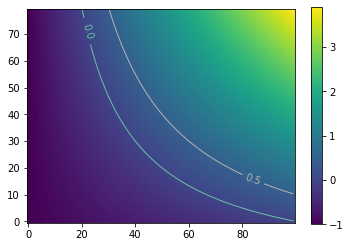

In [40]:
from numpy import arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# the function that I'm going to plot
def z_func(x,y):
    return (x*y - 1)
 
prob = arange(0.0,1.0,0.01)
odd = arange(1.0,5.0,0.05)
X,Y = meshgrid(prob, odd) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid

im = imshow(Z,origin = 'lower') # drawing the function

# adding the Contour lines with labels
cset = contour(Z,[0.0, 0.5],linewidths=1,cmap=cm.Set2)
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)

colorbar(im) # adding the colobar on the right

show()

# Performance analysis

## Calculations of expected gain for each result

In [41]:
performance_df = test_df[['FTR','IWA','IWD','IWH']]
performance_df['P(A)']= pd.DataFrame(data = results['L1 logistic'][:,0], columns = ['P(A)'])
performance_df['E(A)']= performance_df['P(A)'] * performance_df['IWA'] - 1.0
performance_df['P(D)']= pd.DataFrame(data = results['L1 logistic'][:,1], columns = ['P(D)'])
performance_df['E(D)']= performance_df['P(D)'] * performance_df['IWD'] - 1.0
performance_df['P(H)']= pd.DataFrame(data = results['L1 logistic'][:,2], columns = ['P(H)'])
performance_df['E(H)']= performance_df['P(H)'] * performance_df['IWH'] - 1.0
performance_df

,FTR,IWA,IWD,IWH,P(A),E(A),P(D),E(D),P(H),E(H)
50,D,3.40,3.25,2.20,0.206847,-0.296721,0.326517,0.061182,0.466636,0.026599
51,H,5.30,3.80,1.65,0.098136,-0.479877,0.234909,-0.107347,0.666955,0.100475
52,A,2.00,3.40,3.80,0.156232,-0.687536,0.262154,-0.108677,0.581614,1.210133
53,H,18.00,7.50,1.15,0.278422,4.011590,0.286427,1.148205,0.435151,-0.499576
54,A,1.75,3.60,4.80,0.326677,-0.428315,0.282189,0.015880,0.391134,0.877443
...,...,...,...,...,...,...,...,...,...,...
199,A,2.90,3.40,2.40,0.185691,-0.461495,0.226549,-0.229732,0.587759,0.410622
200,D,4.75,4.30,1.65,0.069646,-0.669181,0.166684,-0.283260,0.763670,0.260056
202,A,1.80,3.95,4.15,0.309585,-0.442747,0.283367,0.119300,0.407048,0.689248
203,H,6.10,4.70,1.48,0.723435,3.412952,0.179851,-0.154698,0.096714,-0.856864


## Selection of results to bet on and their actual performances

In [42]:
#Floor and cap on expected gain to consider
floor = 1.0
cap = 4.0

### Draws performance

In [58]:
#Selection of the draws
draw_floor = performance_df['E(D)'] > floor
draw_cap = performance_df['E(D)'] < cap
selected_draw = performance_df[draw_floor & draw_cap]

#Computation of actual gains on draws
selected_draw['Gain'] = 0.0
is_Draw = selected_draw['FTR'] == 'D'
not_Draw = selected_draw['FTR'] != 'D'
selected_draw.loc[not_Draw, 'Gain'] = -1.0
selected_draw.loc[is_Draw, 'Gain'] = selected_draw.loc[is_Draw,'IWD'] - 1.0

### Aways performance

In [59]:
#Selection of the aways
away_floor = performance_df['E(A)'] > floor
away_cap = performance_df['E(A)'] < cap
selected_away = performance_df[away_floor & away_cap]

#Computation of actual gains on aways
selected_away['Gain'] = 0.0
is_Away = selected_away['FTR'] == 'A'
not_Away = selected_away['FTR'] != 'A'
selected_away.loc[not_Away, 'Gain'] = -1.0
selected_away.loc[is_Away, 'Gain'] = selected_away.loc[is_Away,'IWA'] - 1.0

### Homes performance

In [60]:
#Selection of the homes
home_floor = performance_df['E(H)'] > floor
home_cap = performance_df['E(H)'] < cap
selected_home = performance_df[home_floor & home_cap]

#Computation of actual gains on aways
selected_home['Gain'] = 0.0
is_Home = selected_home['FTR'] == 'H'
not_Home = selected_home['FTR'] != 'H'
selected_home.loc[not_Home, 'Gain'] = -1.0
selected_home.loc[is_Home, 'Gain'] = selected_home.loc[is_Home,'IWH'] - 1.0

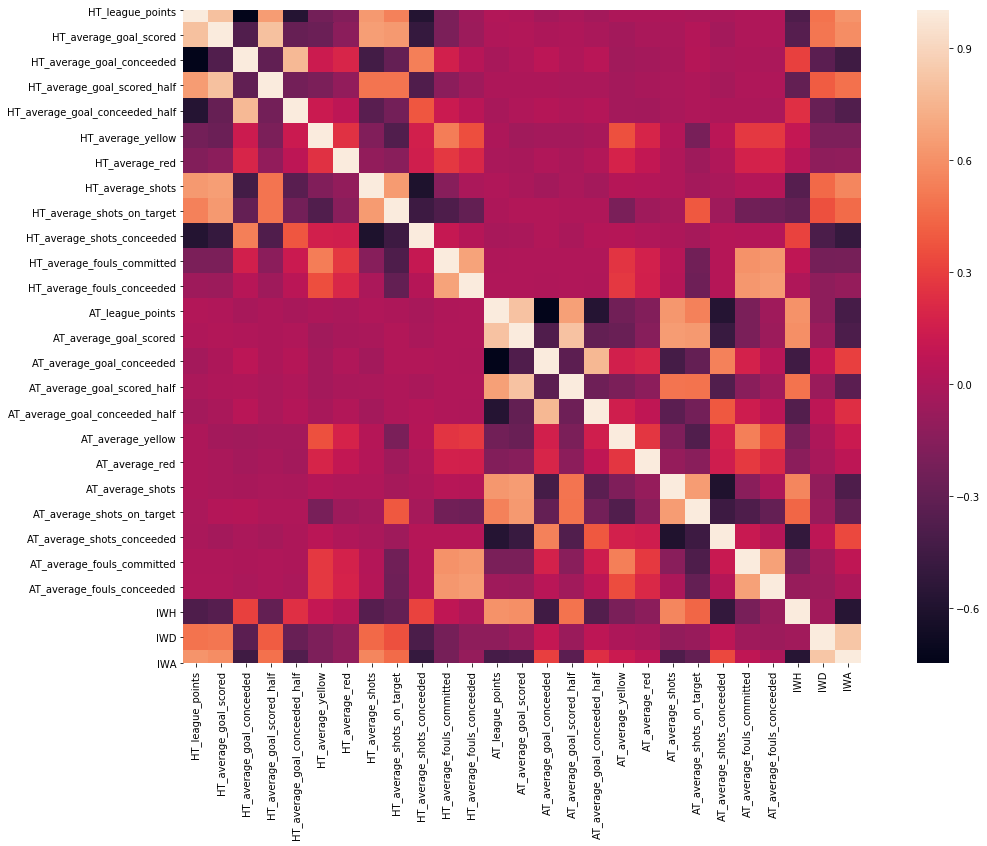

In [46]:
import matplotlib.pyplot as plt
corr_mat = train_df.corr()
fig, ax = plt.subplots(figsize=(20, 12)) 
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax)

In [54]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

n_classes = 3
n_features = train_x.shape[1]

model =tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(10, activation =tf.nn.relu))

#Output layer
model.add(tf.keras.layers.Dense())

In [57]:
train_x.shape[1]

18